In [159]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import sys
import os
from cnmf import cNMF
from matplotlib.gridspec import GridSpec

from fastcluster import linkage
from scipy.cluster.hierarchy import leaves_list
from matplotlib import gridspec


sys.path.append('../../Code/')
from utils import read_dataset_log, ttest_paired_allcols, compute_smooth_scatter_color

In [2]:
figdir = '../../Figures/Components'

In [3]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [4]:
ref_info = read_dataset_log(tabname='Dataset Paths')
ref_info.index = ref_info['dataset']
ref_info

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [5]:
gepname = read_dataset_log(tabname='cGEP_Name')
rename_map = dict(zip(gepname['cGep_Name'], gepname['Short_Name']))

In [6]:
def load_dataset(_dataset, markers=None):
    sampid = ref_info.at[_dataset, 'sample_col']
    meta = pd.read_csv(ref_info.at[_dataset, 'metadata_fn'], sep='\t', index_col=0)
    gating = pd.read_csv(ref_info.at[_dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
    meta['Gate'] = gating.loc[meta.index]
    meta = meta.loc[~meta['Gate'].isnull(), :]
    tcat_usage = pd.read_csv(ref_info.at[_dataset, 'tcat_fn'], sep='\t', index_col=0)
    tcat_usage = tcat_usage.rename(columns=rename_map)
    tcat_usage = tcat_usage.loc[meta.index,:]
    tcat_usage_norm = tcat_usage.div(tcat_usage.sum(axis=1), axis=0)
    tcat_usage_norm_fortest = tcat_usage_norm.copy()
    for s in [sampid, 'Gate']:
        tcat_usage_norm_fortest[s] = meta[s]


    adata = sc.read(ref_info.loc[dataset, 'raw_counts_filt_fn'])
    adata = adata[meta.index, :]

    if markers is not None:
        adt = sc.read(ref_info.loc[dataset, 'tpm_counts_for_cnmf_fn'])
        adt = adt[:, markers][meta.index, :]
        adt = pd.DataFrame(adt.X.toarray(), index=adt.obs.index, columns=markers)
        adt = adt.div(adt.std(axis=0), axis=1)
    else:
        adt = None

    return(tcat_usage_norm_fortest, sampid, meta, adata, adt)

## COMBAT

In [7]:
dataset = 'COMBAT'

vmax = 0.5
adt_vmax=5
nothersample=10000
ngatesample=20000
ticklabelsize=8
labelsize=10
cellfrac_filter = 0.2
cellfrac_usage_filter = 0.1
markers = [ 'AB_CD3-1', 'AB_CD4-2', 'AB_CD8', 'AB_CD45RA', 'AB_CD45RO', 'AB_CCR7', 'AB_CD62L', 'AB_CD27-1']
harmony_vars = ['Pool_ID']
tcat_usage_norm_fortest, sampid, meta, adata, adt = load_dataset(dataset, markers=markers)

Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [8]:
adata.obs['Annotation_cluster_name']
adata.obs.loc[adata.obs['Annotation_minor_subset'].isin(['CD4.TEFF.prolif', 'CD8.TEFF.prolif']), 'Annotation_cluster_name'].astype(str).value_counts()

CD8.TEFF.prolif.1          2689
CD4.TEFF.prolif.1          1893
CD4.TEFF.prolif.2          1549
CD8.TEFF.prolif.2          1329
CD8.TEFF.prolif.3           726
CD4.TEFF.prolif.3           703
CD4.TEFF.prolif.MKI67lo     528
CD8.TEFF.prolif.4            90
CD4.TEFF.prolif.GZMB.1       62
CD8.TEFF.prolif.5            59
CD4.TEFF.prolif.GZMB.2       26
Name: Annotation_cluster_name, dtype: int64

In [9]:
'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset'

('Annotation_cluster_name',
 'Annotation_minor_subset',
 'Annotation_major_subset')

In [10]:
ccgeps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']
tcat_usage_norm_fortest['CellCycle'] = tcat_usage_norm_fortest[ccgeps].sum(axis=1)
tcat_usage_norm_fortest.drop(ccgeps, axis=1, inplace=True)

In [11]:
tcat_usage_norm_fortest = tcat_usage_norm_fortest.drop(['COMBAT_participant_timepoint_ID',	'Gate'], axis=1)

In [12]:
markers_magic = pd.read_csv('../../Data/PerDataset/COMBAT/ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv', sep='\t', index_col=0)

In [13]:
gating = pd.read_csv('../../Data/PerDataset/COMBAT/ManualGating.Magic.FinalLabel.20230831.tsv', sep='\t', index_col=0)['0']

In [14]:
gating.head()

AAACCTGAGCGGATCA-1-gPlexA1       CD8_EM
AAACCTGCAGCTCGAC-1-gPlexA1       CD4_CM
AAACCTGCATCTATGG-1-gPlexA1       CD4_EM
AAACCTGGTCTCTCTG-1-gPlexA1       CD4_CM
AAACCTGTCACCGGGT-1-gPlexA1    CD8_TEMRA
Name: 0, dtype: object

In [15]:
adata.obs['Manual Gating'] = gating.loc[adata.obs.index]

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


In [17]:
all_clusters = ['CD4.NAIVE', 'CD4.TCM', 'CD4.TEFF','CD4.TEFF.prolif','CD4.TEM/TEMRA','CD4.TREG',
 'CD8.NAIVE','CD8.TCM','CD8.TCM.CCL5','CD8.TEFF','CD8.TEFF.prolif','CD8.TEM','CD8.TEMRA','CD8.TREG','CD8.mitohi',
 'DN','DP','GDT.VD2','GDT.VD2neg','MAIT']

cd4_mem_clusters = [ 'CD4.TCM', 'CD4.TEFF', 'CD4.TEFF.prolif', 'CD4.TEM/TEMRA', 'CD4.TREG']

adata.obs['Is_CD4_Mem'] = adata.obs['Annotation_minor_subset'].isin(cd4_mem_clusters)

In [61]:
import colorsys

def hsl_to_rgb(h, s, l):
    return colorsys.hls_to_rgb(h, l, s)


def adjust_color_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

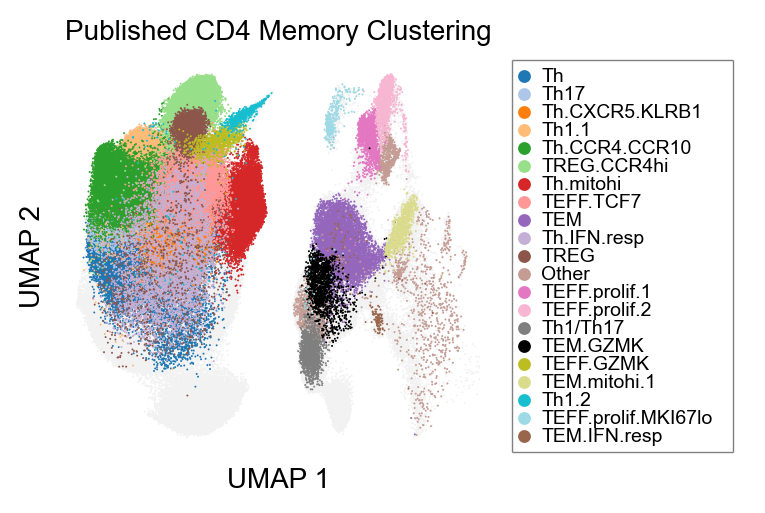

In [141]:

umap_dim = 1.8
leg_dim = 1.
wspace = 0
right = 1
left = .07
bottom = .1
top = .9
fig_width = 3.7
fig_height = 2.5
lab_fs = 10
leg_fs = 7
s=.5


fig = plt.figure(constrained_layout=False, figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[umap_dim, leg_dim],
                       bottom=bottom, left=left, right=right, top=top,  wspace=wspace)

umap_ax = fig.add_subplot(gs[0], frameon=False)
leg_ag = fig.add_subplot(gs[1])


this_ax = umap_ax
umap1 = adata.obsm['X_umap_published'][:,0]
umap2 = adata.obsm['X_umap_published'][:,1]
this_ax.scatter(umap1, umap2, color='.95', edgecolor='None', s=s, label=cluster, rasterized=True)


label = adata.obs.loc[adata.obs['Is_CD4_Mem'], 'Annotation_cluster_name'].astype(str)
umap1 = umap1[adata.obs['Is_CD4_Mem'].values]
umap2 = umap2[adata.obs['Is_CD4_Mem'].values]

vc = label.value_counts()
vcfrac = vc / vc.sum()
repdict = {x:'Other' for x in vcfrac.index[vcfrac<.005]}
repdict['CD4.TEFF.prolif.MKI67lo'] = 'CD4.TEFF.prolif.MKI67lo'
repdict['CD4.TEM.IFN.resp'] = 'CD4.TEM.IFN.resp'
label_clean = label.replace(repdict)
order = label_clean.value_counts().index
colors = sns.color_palette("tab20")
colors[15] = (0, 0, 0)
cbarmapper = dict(zip(order, colors))
cbarmapper['CD4.TEM.IFN.resp'] = (.6, .4, .3)

for cluster in order:
    subind = label_clean==cluster
    this_ax.scatter(umap1[subind], umap2[subind], color=cbarmapper[cluster], edgecolor='None', s=s, label=cluster, rasterized=True)


this_ax.set_xlabel('UMAP 1', fontsize=lab_fs)
this_ax.set_ylabel('UMAP 2', fontsize=lab_fs)
this_ax.set_yticks([])
this_ax.set_xticks([])
this_ax.set_title('Published CD4 Memory Clustering', fontsize=lab_fs)


leg_ag.set_ylim([0, 1])
leg_ag.set_xlim([0, 1])
xpos = .1
for i,ypos in enumerate(np.linspace(.95, .05, len(order))):
    leg_ag.scatter(xpos, ypos, label=order[i], s=13, color=cbarmapper[order[i]])
    if order[i] != 'Other':
        leg_ag.text(xpos+.07, ypos, order[i][4:], ha='left', va='center', fontsize=leg_fs)
    else:
        leg_ag.text(xpos+.07, ypos, order[i], ha='left', va='center', fontsize=leg_fs)
leg_ag.axis('off')

lw=.5
lc = '.5'
leg_ag.hlines(0.01, 0.05, 0.95, lw=lw, color=lc)
leg_ag.hlines(0.99, 0.05, 0.95, lw=lw, color=lc)
leg_ag.vlines(0.05, 0.01, 0.99, lw=lw, color=lc)
leg_ag.vlines(0.95, 0.01, 0.99, lw=lw, color=lc)
leg_ag.axis('off')

plt.savefig(os.path.join(figdir, 'Clustering.COMBAT.CD4.NonNaive.png'))
plt.savefig(os.path.join(figdir, 'Clustering.COMBAT.CD4.NonNaive.pdf'))

In [142]:
tcat_usage_norm_fortest.columns

Index(['Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC', 'gdT', 'Cytotoxic',
       'Doublet-Platelet', 'NME1/FABP5', 'Th22', 'MAIT', 'Cytoskeleton',
       'Heatshock', 'Multi-Cytokine', 'TEMRA', 'Doublet-Myeloid',
       'Metallothionein', 'CD4-CM', 'IEG', 'CD8-EM', 'IEG2', 'CD4-Naive',
       'Treg', 'Th17-Resting', 'Poor-Quality', 'CD8-Naive', 'RGCC/MYADM',
       'TIMD4/TIM3', 'Doublet-Plasmablast', 'BCL2/FAM13A', 'IL10/IL19',
       'Th2-Activated', 'Th2-Resting', 'ICOS/CD38', 'Doublet-Bcell',
       'Th1-Like', 'CTLA4/CD38', 'CD8-Trm', 'Th17-Activated', 'Tfh-2',
       'OX40/EBI3', 'CD172a/MERTK', 'IEG3', 'Doublet-Fibroblast', 'SOX4/TOX2',
       'CD40LG/TXNIP', 'Tph', 'Exhaustion', 'Tfh-1', 'CellCycle'],
      dtype='object')

In [143]:
ind = adata.obs.index[adata.obs['Is_CD4_Mem']]
usage_for_plot = tcat_usage_norm_fortest.loc[ind, ['Poor-Quality', 'Cytotoxic', 'ISG']]
usage_for_plot['Cluster'] = adata.obs.loc[ind, 'Annotation_cluster_name'].values.astype(str)
usage_for_plot['Gating'] = adata.obs.loc[ind, 'Manual Gating'].values.astype(str)

#usage_for_plot = usage_for_plot.rename(columns={'TIMD4/TIM3-Activation':'TIMD4/TIM3', 'IL10/IL19-Secretion':'IL10/IL19'})

In [144]:
order = usage_for_plot.groupby('Cluster')['Poor-Quality'].mean().sort_values(ascending=False).index

color_ordered = []
for o in order:
    if o not in repdict.keys():
        color_ordered.append(cbarmapper[o])
    else:
        color_ordered.append(cbarmapper[repdict[o]])

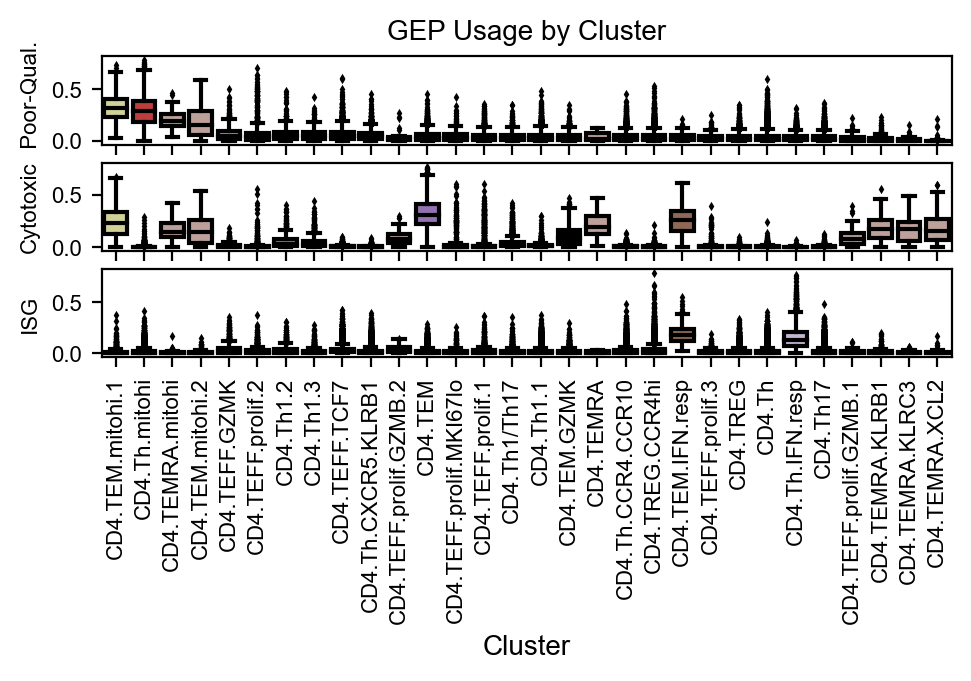

In [145]:
(fig,axes) = plt.subplots(3,1, figsize=(5,3.5), dpi=200, gridspec_kw={'bottom':.45, 'left':.1, 'right':.95})
for i,g in enumerate(['Poor-Quality', 'Cytotoxic', 'ISG']):
    sns.boxplot(x='Cluster', y=g, data=usage_for_plot, ax=axes[i], order=order, fliersize=1, palette=color_ordered)
    if i < (len(axes) - 1):
        _ = axes[i].set_xticklabels([])
    else:
        _ = axes[i].set_xticklabels(order, rotation=90, fontsize=8)
    axes[i].set_ylabel(g.replace('-Quality', '-Qual.').replace('Poor', '  Poor'), fontsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    #axes[i].set_yticklabels(labels, fontsize=8)

#axes[3].set_yticks([0,.3]) 
axes[0].set_title('GEP Usage by Cluster', fontsize=10)

plt.savefig(os.path.join(figdir, 'CCOMBAT.UsageBoxPlot.ByCluster.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.UsageBoxPlot.ByCluster.pdf'))

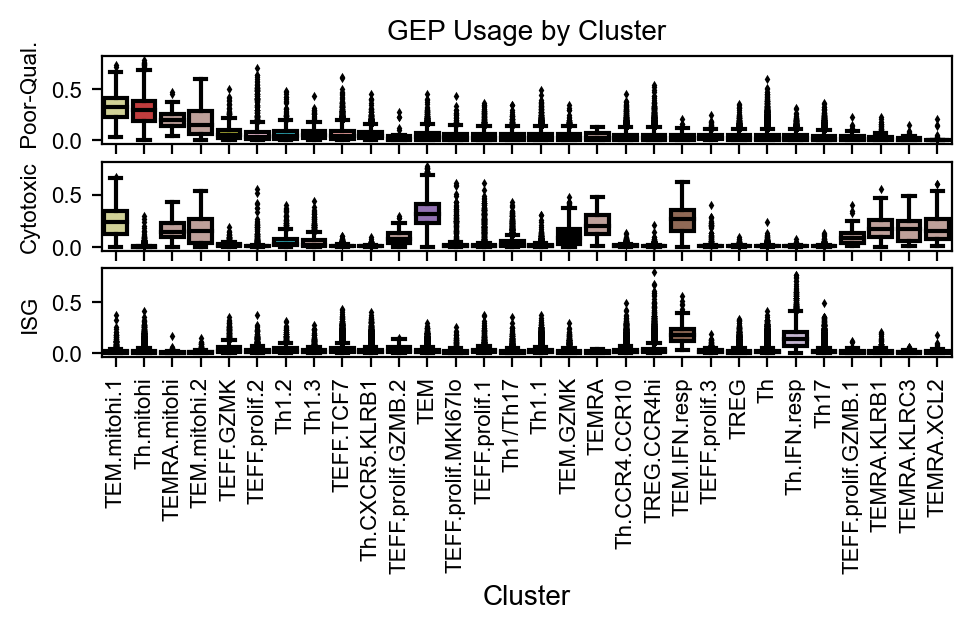

In [146]:
(fig,axes) = plt.subplots(3,1, figsize=(5,3.5), dpi=200, gridspec_kw={'bottom':.45, 'left':.1, 'right':.95})
for i,g in enumerate(['Poor-Quality', 'Cytotoxic', 'ISG']):
    sns.boxplot(x='Cluster', y=g, data=usage_for_plot, ax=axes[i], order=order, fliersize=1, palette=color_ordered)
    if i < (len(axes) - 1):
        _ = axes[i].set_xticklabels([])
    else:
        _ = axes[i].set_xticklabels([x[4:] for x in order], rotation=90, fontsize=8)
    axes[i].set_ylabel(g.replace('-Quality', '-Qual.').replace('Poor', '  Poor'), fontsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    #axes[i].set_yticklabels(labels, fontsize=8)

#axes[3].set_yticks([0,.3]) 
axes[0].set_title('GEP Usage by Cluster', fontsize=10)

plt.savefig(os.path.join(figdir, 'CCOMBAT.UsageBoxPlot.ByCluster.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.UsageBoxPlot.ByCluster.pdf'))

In [147]:
ind = adata.obs.index[adata.obs['Is_CD4_Mem']]
usage_for_plot = tcat_usage_norm_fortest.loc[ind, ['Poor-Quality', 'Cytotoxic', 'ISG', 'IL10/IL19', 'Translation', 'TIMD4/TIM3']]
usage_for_plot['Cluster'] = adata.obs.loc[ind, 'Annotation_cluster_name'].values.astype(str)
usage_for_plot['Gating'] = adata.obs.loc[ind, 'Manual Gating'].values.astype(str)

usage_for_plot = usage_for_plot.rename(columns={'TIMD4/TIM3-Activation':'TIMD4/TIM3', 'IL10/IL19-Secretion':'IL10/IL19'})

In [148]:
order = usage_for_plot.groupby('Cluster')['Poor-Quality'].mean().sort_values(ascending=False).index

color_ordered = []
for o in order:
    if o not in repdict.keys():
        color_ordered.append(cbarmapper[o])
    else:
        color_ordered.append(cbarmapper[repdict[o]])

In [151]:
sorted(clusterdat_toplot.columns)

['BCL2/FAM13A',
 'CD4-CM',
 'CD4-Naive',
 'CD40LG/TXNIP',
 'CD8-EM',
 'CTLA4/CD38',
 'CellCycle',
 'Cytotoxic',
 'Doublet-Myeloid',
 'IL10/IL19',
 'ISG',
 'MAIT',
 'NME1/FABP5',
 'Poor-Quality',
 'TEMRA',
 'Th1-Like',
 'Th17-Resting',
 'Th2-Resting',
 'Th22',
 'Translation',
 'Treg',
 'gdT']

In [153]:
tcat_usage_norm_fortest.loc[ind, :].groupby(adata.obs.loc[ind, 'Annotation_cluster_name'].astype(str)).mean().loc['CD4.Th1.2', :].sort_values(ascending=False)

Poor-Quality           0.064962
Th1-Like               0.055677
Cytotoxic              0.054362
CD4-Naive              0.046144
Translation            0.043663
CD8-EM                 0.038537
CD40LG/TXNIP           0.037496
ISG                    0.036121
Doublet-Plasmablast    0.033553
TIMD4/TIM3             0.025236
Th22                   0.023669
MAIT                   0.023298
BCL2/FAM13A            0.022503
gdT                    0.022346
Doublet-Myeloid        0.022225
TEMRA                  0.022135
Th2-Resting            0.021688
CD8-Naive              0.021609
Th17-Resting           0.021578
IEG                    0.021560
Treg                   0.021072
CTLA4/CD38             0.017438
Tph                    0.017086
CD172a/MERTK           0.016896
HLA                    0.016832
Exhaustion             0.016483
RGCC/MYADM             0.016356
CD4-CM                 0.016172
ICOS/CD38              0.015088
Mito                   0.014291
Multi-Cytokine         0.013694
IEG2    

In [154]:
shorten_map = dict(zip(gepname['Short_Name'], gepname['Shortest_Name']))
shorten_map['CellCycle'] = 'CellCycle'

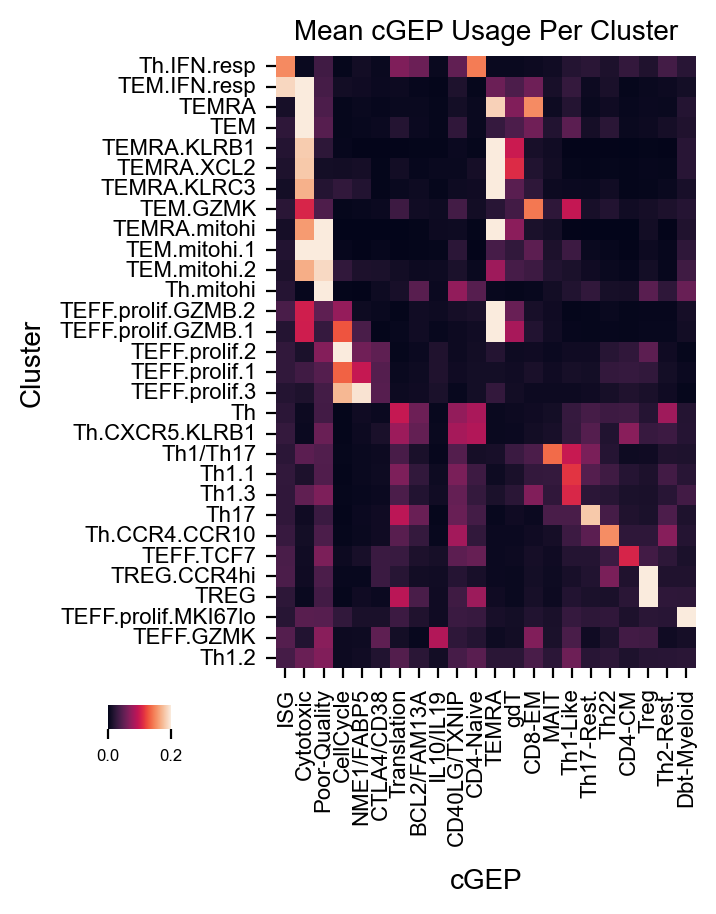

In [156]:
colorder = ['ISG', 'Cytotoxic','Poor-Quality',   'CellCycle', 'NME1/FABP5',  'CTLA4/CD38',
            'Translation',  'BCL2/FAM13A', 'IL10/IL19','CD40LG/TXNIP', 'CD4-Naive',
            'TEMRA', 'gdT','CD8-EM', 'MAIT', 'Th1-Like', 'Th17-Resting', 'Th22', 
            'CD4-CM', 'Treg',  'Th2-Resting',  'Doublet-Myeloid']


roworder = ['CD4.Th.IFN.resp', 'CD4.TEM.IFN.resp', 
            'CD4.TEMRA', 'CD4.TEM', 'CD4.TEMRA.KLRB1', 'CD4.TEMRA.XCL2',  'CD4.TEMRA.KLRC3',  'CD4.TEM.GZMK',
            'CD4.TEMRA.mitohi', 'CD4.TEM.mitohi.1','CD4.TEM.mitohi.2', 'CD4.Th.mitohi',
              'CD4.TEFF.prolif.GZMB.2', 'CD4.TEFF.prolif.GZMB.1', 
            'CD4.TEFF.prolif.2', 'CD4.TEFF.prolif.1',  'CD4.TEFF.prolif.3',

            'CD4.Th',  'CD4.Th.CXCR5.KLRB1', 
            'CD4.Th1/Th17',
            'CD4.Th1.1',  'CD4.Th1.3', 
             
            'CD4.Th17',
             'CD4.Th.CCR4.CCR10',
             'CD4.TEFF.TCF7', 
            'CD4.TREG.CCR4hi', 'CD4.TREG', 
           
            
             'CD4.TEFF.prolif.MKI67lo', 
            
            
            'CD4.TEFF.GZMK', 
            
           

       
       'CD4.Th1.2',
       ]




(fig,ax) = plt.subplots(1,1, figsize=(3.5,4.5), dpi=200, gridspec_kw={'left':.37, 'right':.97, 'bottom':.26, 'top':.94})
cax = ax.inset_axes([-0.4, -0.1, .15, 0.04], transform=ax.transAxes, zorder=-1)

sns.heatmap(clusterdat_toplot.loc[roworder, colorder], vmin=0, vmax=.2, xticklabels=True, yticklabels=True, ax=ax, 
           cbar_ax=cax, cbar_kws={'orientation':'horizontal', 'ticks':[0, .2]})

cax.tick_params(labelsize=6)


_ = ax.set_yticklabels([x[4:] for x in roworder], fontsize=8)
_ = ax.set_xticklabels([shorten_map[x] for x in colorder], fontsize=8)

ax.set_ylabel('Cluster', fontsize=10, labelpad=5)
ax.set_xlabel('cGEP', fontsize=10, labelpad=8)


ax.set_title('Mean cGEP Usage Per Cluster', fontsize=10, y=1)

plt.savefig(os.path.join(figdir, 'COMBAT.Heatmap.AverageUsage.ByCluster.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.Heatmap.AverageUsage.ByCluster.pdf'))

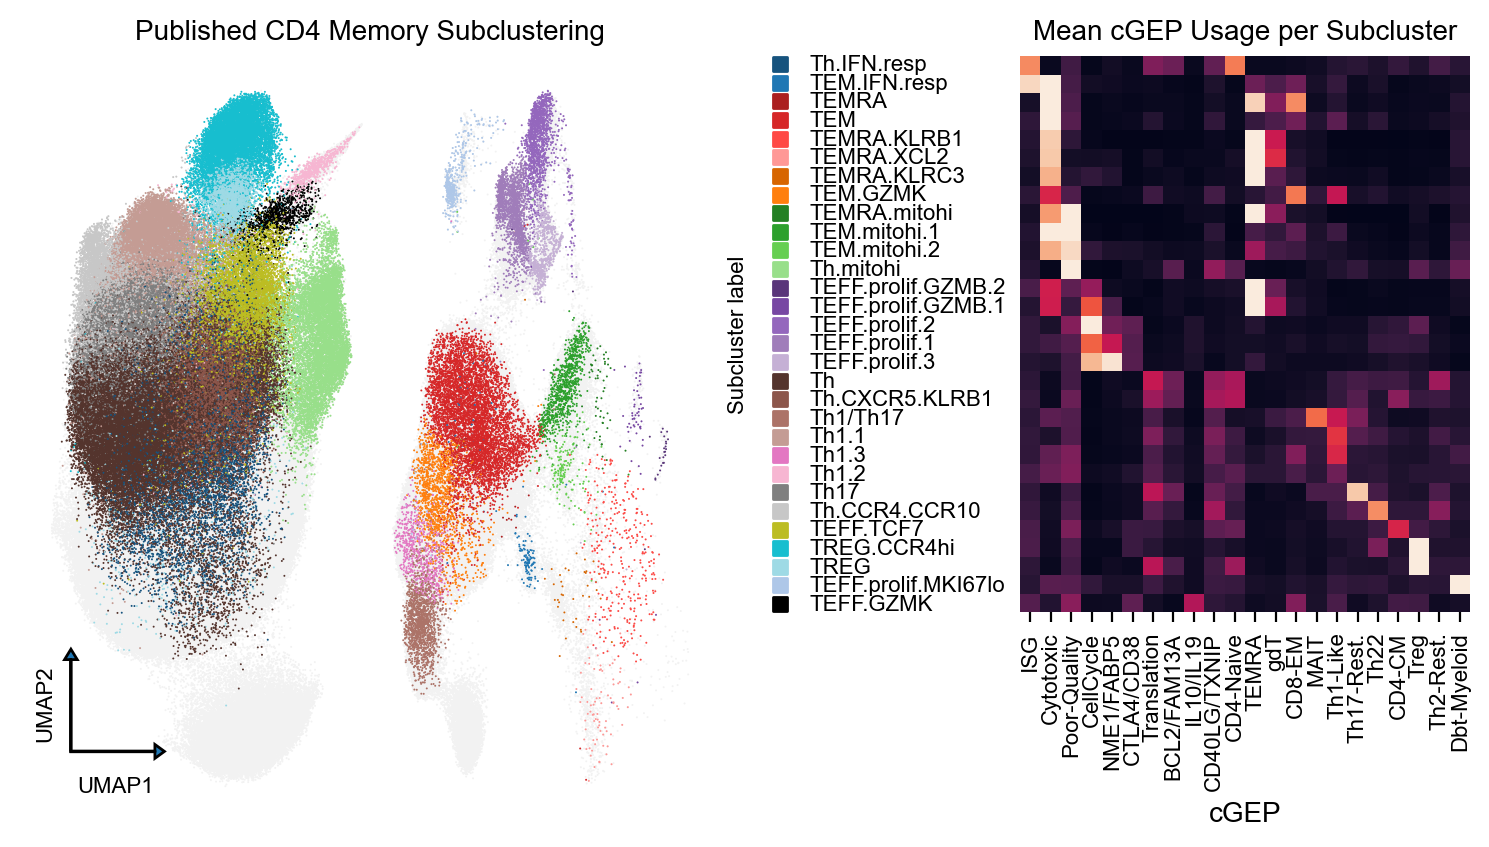

In [369]:
colorder = ['ISG', 'Cytotoxic','Poor-Quality',   'CellCycle', 'NME1/FABP5',  'CTLA4/CD38',
            'Translation',  'BCL2/FAM13A', 'IL10/IL19','CD40LG/TXNIP', 'CD4-Naive',
            'TEMRA', 'gdT','CD8-EM', 'MAIT', 'Th1-Like', 'Th17-Resting', 'Th22', 
            'CD4-CM', 'Treg',  'Th2-Resting',  'Doublet-Myeloid']


clusterorder = ['CD4.Th.IFN.resp', 'CD4.TEM.IFN.resp', 
            'CD4.TEMRA', 'CD4.TEM', 'CD4.TEMRA.KLRB1', 'CD4.TEMRA.XCL2',  'CD4.TEMRA.KLRC3',  'CD4.TEM.GZMK',
            'CD4.TEMRA.mitohi', 'CD4.TEM.mitohi.1','CD4.TEM.mitohi.2', 'CD4.Th.mitohi',
              'CD4.TEFF.prolif.GZMB.2', 'CD4.TEFF.prolif.GZMB.1', 
            'CD4.TEFF.prolif.2', 'CD4.TEFF.prolif.1',  'CD4.TEFF.prolif.3',

            'CD4.Th',  'CD4.Th.CXCR5.KLRB1', 
            'CD4.Th1/Th17',
            'CD4.Th1.1',  'CD4.Th1.3', 'CD4.Th1.2',
             
            'CD4.Th17',
             'CD4.Th.CCR4.CCR10',
             'CD4.TEFF.TCF7', 
            'CD4.TREG.CCR4hi', 'CD4.TREG', 
             'CD4.TEFF.prolif.MKI67lo',          
            'CD4.TEFF.GZMK', 
       ]




fig = plt.figure(figsize=(7.25,4.5), dpi=200)
gs = GridSpec(2, 3, height_ratios=[1,.25], width_ratios=[3.5, 1.5, 2.25], wspace=0, left=0, right=1, bottom=0.1, top = .95)
umap_ax = fig.add_subplot(gs[:, 0])
leg_ax = fig.add_subplot(gs[0, 1])
heatmap_ax = fig.add_subplot(gs[0, 2])


this_ax = umap_ax
umap1 = adata.obsm['X_umap_published'][:,0]
umap2 = adata.obsm['X_umap_published'][:,1]
umap1 -= umap1.min()
umap2 -= umap2.min()
umap1 /= umap1.max()
umap2 /= umap2.max()

this_ax.scatter(umap1, umap2, color='.95', edgecolor='None', s=s, label=cluster, rasterized=True)

umap1 = umap1[adata.obs['Is_CD4_Mem'].values]
umap2 = umap2[adata.obs['Is_CD4_Mem'].values]

label = adata.obs.loc[adata.obs['Is_CD4_Mem'], 'Annotation_cluster_name'].astype(str)


colors = sns.color_palette("tab20")

color_order = [adjust_color_lightness(colors[0], amount=0.7), colors[0], # 'CD4.Th.IFN.resp', 'CD4.TEM.IFN.resp', 
               adjust_color_lightness(colors[6], amount=0.8), colors[6],  adjust_color_lightness(colors[7], amount=0.8), colors[7], # 'CD4.TEMRA',- 'CD4.TEMRA.XCL2', 
               adjust_color_lightness(colors[2], amount=0.8), colors[2],  #  'CD4.TEMRA.KLRC3' - 'CD4.TEM.GZMK',
               adjust_color_lightness(colors[4], amount=0.8), colors[4], adjust_color_lightness(colors[5], amount=0.8),  colors[5], # 'CD4.TEMRA.mitohi' - 'CD4.Th.mitohi',
               adjust_color_lightness(colors[8], amount=0.6), adjust_color_lightness(colors[8], amount=0.8), colors[8], adjust_color_lightness(colors[9], amount=0.8),  colors[9], #CD4.TEFF.prolif.GZMB.2' - 'CD4.TEFF.prolif.3'
               adjust_color_lightness(colors[10], amount=0.6), colors[10], adjust_color_lightness(colors[11], amount=0.8), colors[11], # CD4.Th - CD4.Th1.1
               colors[12], colors[13], colors[14], colors[15], colors[16], 
               colors[18], colors[19], # CD4.TREG.CCR4hi - CD4.TREG
               colors[1], # CD4.TEFF.prolif.MKI67lo
               (0.,0.,0.) # CD4.TEFF.GZMK
              ]
               
cbarmapper = dict(zip(clusterorder, color_order))
plotcolor = np.array([cbarmapper[x] for x in label])
this_ax.scatter(umap1, umap2, c=plotcolor, edgecolor='None', s=s,  rasterized=True)



#for cluster in clusterorder:
#    subind = label==cluster
#    this_ax.scatter(umap1[subind], umap2[subind], color=cbarmapper[cluster], edgecolor='None', s=s, label=cluster, rasterized=True)


#this_ax.set_xlabel('UMAP 1', fontsize=lab_fs)
#this_ax.set_ylabel('UMAP 2', fontsize=lab_fs)
this_ax.set_yticks([])
this_ax.set_xticks([])
this_ax.set_title('Published CD4 Memory Subclustering', fontsize=10)
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)
this_ax.spines['left'].set_visible(False)
this_ax.spines['bottom'].set_visible(False)
xlim = this_ax.get_xlim()
ylim = this_ax.get_ylim()
this_ax.arrow(xlim[0]+.08, ylim[0]+.1, .12*(xlim[1] - xlim[0]), 0, head_width=.02, head_length=.015)
this_ax.arrow(xlim[0]+.08, ylim[0]+.1, 0, .12*(ylim[1] - ylim[0]), head_width=.02, head_length=.015)
this_ax.text(.1, 0, 'UMAP1', ha='center', va='center', fontsize=8)
this_ax.text(-.01, .12, 'UMAP2', ha='center', va='center', fontsize=8, rotation=90)


#this_ax.plot([xlim[0], xlim[0]], [ylim[0], ylim[0]+.05*(ylim[1] - ylim[0])], color='k', lw=1)
             


leg_ax.set_ylim([-.005, 1.005])
leg_ax.set_xlim([0, 1])
xpos = .2
for i,ypos in enumerate(np.linspace(.99, .01, len(clusterorder))):
    leg_ax.scatter(xpos, ypos, label=clusterorder[i], s=25, color=cbarmapper[clusterorder[i]], marker='s')
    leg_ax.text(xpos+.1, ypos, clusterorder[i][4:], ha='left', va='center', fontsize=8)
leg_ax.axis('off')
leg_ax.text(0.025, 0.5, 'Subcluster label', rotation=90, va='center', ha='left', fontsize=8)


sns.heatmap(clusterdat_toplot.loc[clusterorder, colorder], vmin=0, vmax=.2, xticklabels=True, yticklabels=True, ax=heatmap_ax, 
           cbar_ax=cax, cbar_kws={'orientation':'horizontal', 'ticks':[0, .2]})

cax.tick_params(labelsize=6)


#_ = heatmap_ax.set_yticklabels([x[4:] for x in clusterorder], fontsize=8)
_ = heatmap_ax.set_yticklabels([], fontsize=8)
_ = heatmap_ax.set_yticks([])
_ = heatmap_ax.set_xticklabels([shorten_map[x] for x in colorder], fontsize=8)

heatmap_ax.set_ylabel('', fontsize=10, labelpad=5)
heatmap_ax.set_xlabel('cGEP', fontsize=10, labelpad=4)
heatmap_ax.set_title('Mean cGEP Usage per Subcluster', fontsize=10)

plt.savefig(os.path.join(figdir, 'COMBAT.UMAP.AND.Heatmap.AverageUsage.ByCluster.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.UMAP.AND.Heatmap.AverageUsage.ByCluster.pdf'))

In [255]:
lineages = list(gepname.loc[gepname['Class']=='Lineage', 'Short_Name'])

In [256]:
maxlin = tcat_usage_norm_fortest.loc[:, lineages].idxmax(axis=1)
maxlinval = tcat_usage_norm_fortest.loc[:, lineages].max(axis=1)
adata.obs.loc[tcat_usage_norm_fortest.index, 'Max_Lineage'] = maxlin
adata.obs.loc[tcat_usage_norm_fortest.index, 'Max_Lineage_Value'] = maxlinval
adata.obs['Max_Lineage'].value_counts()

CD4-Naive       150613
CD8-EM           47474
CD8-Naive        33663
Th2-Resting      23299
Th17-Resting     22366
Th1-Like         22172
Treg             18893
TEMRA            17878
Th22             14997
CD4-CM           13457
gdT              10827
MAIT              8861
CD8-Trm           6686
Tfh-2             3207
Tfh-1             2786
Tph               2420
Name: Max_Lineage, dtype: int64

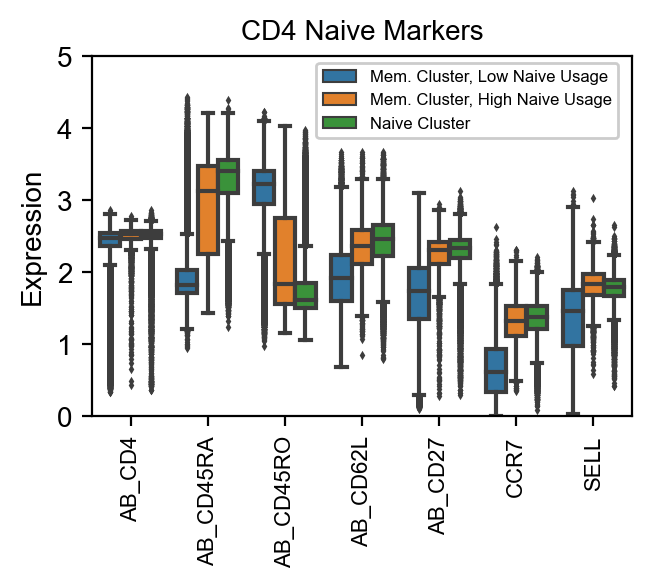

In [257]:
adata.obs['Naive_Status'] = np.nan
ind = adata.obs['Annotation_minor_subset']=='CD4.NAIVE'
adata.obs.loc[ind, 'Naive_Status'] = 'Naive Cluster'

#ind = adata.obs['Is_CD4_Mem'] & (tcat_usage_norm_fortest['CD4-Naive']>.2)
ind = adata.obs['Is_CD4_Mem'] & (adata.obs['Max_Lineage'] == 'CD4-Naive') & (tcat_usage_norm_fortest['CD4-Naive']>.2)
adata.obs.loc[ind, 'Naive_Status'] = 'Mem. Cluster, High Naive Usage'


#ind = adata.obs['Is_CD4_Mem'] & (tcat_usage_norm_fortest['CD4-Naive']<.01)
#ind = adata.obs['Is_CD4_Mem'] & adata.obs['Max_Lineage'].isin(['Th2-1', 'Th17', 'CD4-EM', 'NK-like', 'CD4-CM', 'Tfh-2', 'Thf-1', 'Tph', 'Th2-2', 'Th17-2']) & (tcat_usage_norm_fortest['CD4-Naive']<.01)
ind = adata.obs['Is_CD4_Mem'] & ~((adata.obs['Max_Lineage'] == 'CD4-Naive') & (tcat_usage_norm_fortest['CD4-Naive']>.2))
adata.obs.loc[ind, 'Naive_Status'] = 'Mem. Cluster, Low Naive Usage'

genes = ['AB_CD4-2', 'AB_CD45RA', 'AB_CD45RO', 'AB_CD62L', 'AB_CD27-1',  'CCR7', 'SELL']


merge_info = pd.merge(left=markers_magic.loc[adata.obs.index, genes].unstack().reset_index(), right=adata.obs[['Naive_Status']], left_on='level_1', right_index=True, how='left').dropna()

(fig,ax) = plt.subplots(1,1, figsize=(4,3), dpi=200, gridspec_kw={'right':.8, 'bottom':.3, 'top':.9})
sns.boxplot(hue='Naive_Status', y=0, x='level_0', data=merge_info, ax=ax, fliersize=1, hue_order=['Mem. Cluster, Low Naive Usage', 'Mem. Cluster, High Naive Usage', 'Naive Cluster'])

ax.set_xticklabels([g.split('-')[0] for g in genes], rotation =90, fontsize=8)
ax.set_ylabel('Expression', fontsize=10)
ax.set_xlabel('')
ax.set_title('CD4 Naive Markers', fontsize=10)
ax.set_ylim([0,5])
ax.legend(bbox_to_anchor=(.4, .75), fontsize=6, framealpha=1)

plt.savefig(os.path.join(figdir, 'COMBAT.CD4.NaiveMarkers.BySubset.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.CD4.NaiveMarkers.BySubset.pdf'))

In [258]:
vc = adata.obs['Naive_Status'].value_counts()
vc

Mem. Cluster, Low Naive Usage     140196
Naive Cluster                     123291
Mem. Cluster, High Naive Usage      5279
Name: Naive_Status, dtype: int64

In [259]:
vc.at['Mem. Cluster, High Naive Usage'] /  (vc.at['Mem. Cluster, High Naive Usage'] + vc.at['Mem. Cluster, Low Naive Usage'])

0.036288021996906686

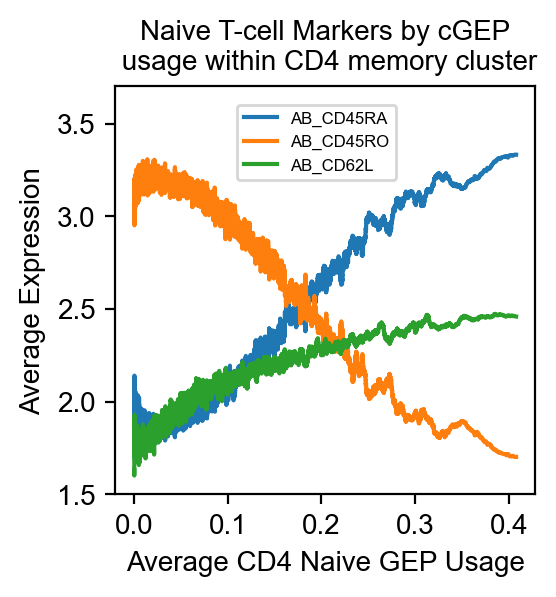

In [260]:
merge_stacked = pd.merge(left=markers_magic.loc[adata.obs.index, genes], right=tcat_usage_norm_fortest['CD4-Naive'], left_index=True, right_index=True, how='left')
merge_stacked = merge_stacked.loc[adata.obs['Is_CD4_Mem']==True, :]
merge_stacked = merge_stacked.sort_values(by='CD4-Naive', ascending=True)
merge_stacked_windowed = merge_stacked.rolling(window=200, center=True).mean().dropna()

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':.2, 'bottom':.2})
for g in ['AB_CD45RA', 'AB_CD45RO', 'AB_CD62L']:
    ax.plot(merge_stacked_windowed['CD4-Naive'], merge_stacked_windowed[g], label=g, rasterized=True)


ax.set_ylabel('Average Expression', fontsize=10)
ax.set_xlabel('Average CD4 Naive GEP Usage', fontsize=10)
ax.set_title('Naive T-cell Markers by cGEP\n usage within CD4 memory cluster', fontsize=10)
ax.legend(bbox_to_anchor=(.27, .75), fontsize=6)
ax.set_ylim([1.5,3.7])
plt.savefig(os.path.join(figdir, 'COMBAT.CD4.NaiveMarkers.ByNaiveGEPExpression.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.CD4.NaiveMarkers.ByNaiveGEPExpression.pdf'))

In [261]:
adata_sub = adata[adata.obs['Annotation_minor_subset'].isin(cd4_mem_clusters), :]
adata_sub.obs['Annotation_cluster_name2'] = adata_sub.obs['Annotation_cluster_name'].values.astype(str)


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


In [262]:
list(adata_sub.obs['Annotation_cluster_name2'].unique())

['CD4.Th',
 'CD4.TREG.CCR4hi',
 'CD4.TEFF.TCF7',
 'CD4.Th.CCR4.CCR10',
 'CD4.TEFF.prolif.1',
 'CD4.Th1.1',
 'CD4.Th17',
 'CD4.TEMRA.KLRB1',
 'CD4.TREG',
 'CD4.TEFF.GZMK',
 'CD4.Th.mitohi',
 'CD4.Th.IFN.resp',
 'CD4.Th.CXCR5.KLRB1',
 'CD4.Th1/Th17',
 'CD4.TEM.mitohi.1',
 'CD4.TEM',
 'CD4.TEFF.prolif.3',
 'CD4.TEM.GZMK',
 'CD4.TEFF.prolif.2',
 'CD4.Th1.2',
 'CD4.TEFF.prolif.MKI67lo',
 'CD4.TEM.mitohi.2',
 'CD4.TEMRA.XCL2',
 'CD4.Th1.3',
 'CD4.TEFF.prolif.GZMB.2',
 'CD4.TEMRA.mitohi',
 'CD4.TEMRA.KLRC3',
 'CD4.TEM.IFN.resp',
 'CD4.TEFF.prolif.GZMB.1',
 'CD4.TEMRA']

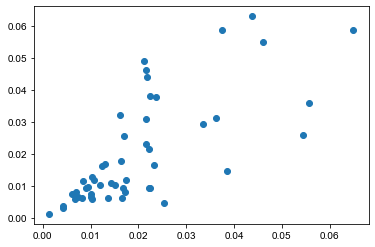

In [263]:
X = tcat_usage_norm_fortest.loc[adata_sub.obs.index[adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.Th1.2'])], :].mean(axis=0)
Y = tcat_usage_norm_fortest.loc[adata_sub.obs.index[~adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.Th1.2'])], :].mean(axis=0)
plt.scatter(X, Y)

In [264]:
dat = pd.concat([X,Y], axis=1)
dat['ratio'] = dat[0]/dat[1]
dat.sort_values(by='ratio', ascending=False)

,0,1,ratio
TIMD4/TIM3,0.025236,0.004598,5.488513
Exhaustion,0.016483,0.006150,2.680276
CD8-EM,0.038537,0.014619,2.636123
TEMRA,0.022135,0.009173,2.413137
gdT,0.022346,0.009353,2.389123
Multi-Cytokine,0.013694,0.006222,2.200808
Tph,0.017086,0.008104,2.108495
Cytotoxic,0.054362,0.025787,2.108082
HLA,0.016832,0.009357,1.798872
CD8-Trm,0.010183,0.005953,1.710492


In [265]:
Z = tcat_usage_norm_fortest.loc[adata_sub.obs.index[adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.Th1.2'])], :] # , 'CD4.TEFF.GZMK'
#Z = tcat_usage_norm_fortest.loc[adata_sub.obs.index[adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.TEFF.GZMK'])], :] # 
std = Z.std(axis=0).sort_values(ascending=False)
tokeep = list(std.index[std>.03])
std

Poor-Quality           0.068610
Th1-Like               0.066296
Cytotoxic              0.064437
CD4-Naive              0.063941
Translation            0.056019
CD8-EM                 0.053144
ISG                    0.048021
TIMD4/TIM3             0.047061
SOX4/TOX2              0.040748
TEMRA                  0.040745
MAIT                   0.039771
Treg                   0.039490
Doublet-Plasmablast    0.038254
BCL2/FAM13A            0.037679
Doublet-Fibroblast     0.037316
IEG                    0.036844
CD40LG/TXNIP           0.036405
Th22                   0.036404
HLA                    0.034544
Doublet-Myeloid        0.032361
CD8-Naive              0.031637
Th17-Resting           0.030808
CTLA4/CD38             0.030641
Multi-Cytokine         0.030290
Tph                    0.030110
Th2-Resting            0.028273
Exhaustion             0.027166
RGCC/MYADM             0.025568
Doublet-Bcell          0.024048
IL10/IL19              0.024020
ICOS/CD38              0.023378
Mito    

In [269]:
umap1 = adata.obsm['X_umap_published'][:,0]
umap2 = adata.obsm['X_umap_published'][:,1]

umap1 = umap1[adata.obs['Is_CD4_Mem'].values]
umap2 = umap2[adata.obs['Is_CD4_Mem'].values]

In [270]:
tcat_usage_norm_fortest_smooth = tcat_usage_norm_fortest.loc[adata_sub.obs.index,:]
for g in tcat_usage_norm_fortest_smooth.columns:
    z_avg = compute_smooth_scatter_color(umap1, umap2, tcat_usage_norm_fortest_smooth[g].values, n_neighbors=20)
    tcat_usage_norm_fortest_smooth[g] = z_avg
    

In [271]:
adata_sub_cp = adata_sub.copy()
adata_sub_cp.obs = pd.concat([adata_sub_cp.obs, tcat_usage_norm_fortest_smooth], axis=1)

In [272]:
shorten_map

{'Cytoskeleton': 'Cytosk.',
 'CD8-EM': 'CD8-EM',
 'CellCycle-G2M': 'G2M-phase',
 'CellCycle-S': 'S-phase',
 'Cytotoxic': 'Cytotoxic',
 'Doublet-RBC': 'Dbt-RBC',
 'ISG': 'ISG',
 'MAIT': 'MAIT',
 'Treg': 'Treg',
 'CD4-Naive': 'CD4-Naive',
 'CellCycle-Late-S': 'Late-S-phase',
 'HLA': 'HLA',
 'NME1/FABP5': 'NME1/FABP5',
 'IEG': 'IEG',
 'Poor-Quality': 'Poor-Quality',
 'Translation': 'Translation',
 'TEMRA': 'TEMRA',
 'CD4-CM': 'CD4-CM',
 'Doublet-Platelet': 'Dbt-Platelet',
 'IL10/IL19': 'IL10/IL19',
 'RGCC/MYADM': 'RGCC/MYADM',
 'Mito': 'Mito',
 'Doublet-Plasmablast': 'Dbt-Plasmablast',
 'gdT': 'gdT',
 'Metallothionein': 'Metallothionein',
 'IEG2': 'IEG2',
 'Multi-Cytokine': 'Multi-Cytokine',
 'Th22': 'Th22',
 'Th17-Resting': 'Th17-Rest.',
 'Th2-Resting': 'Th2-Rest.',
 'BCL2/FAM13A': 'BCL2/FAM13A',
 'Th1-Like': 'Th1-Like',
 'CD8-Naive': 'CD8-Naive',
 'CD8-Trm': 'CD8-Trm',
 'CTLA4/CD38': 'CTLA4/CD38',
 'Doublet-Bcell': 'Dbt-Bcell',
 'Doublet-Myeloid': 'Dbt-Myeloid',
 'Heatshock': 'Heatshock

0 0 CD4-Naive
1 0 TEMRA
2 0 CD4-CM
0 1 Th17-Resting
1 1 Th2-Resting
2 1 Th1-Like
0 2 CellCycle
1 2 Cytotoxic
2 2 ISG
0 3 Poor-Quality
1 3 Mito
2 3 Doublet-Myeloid


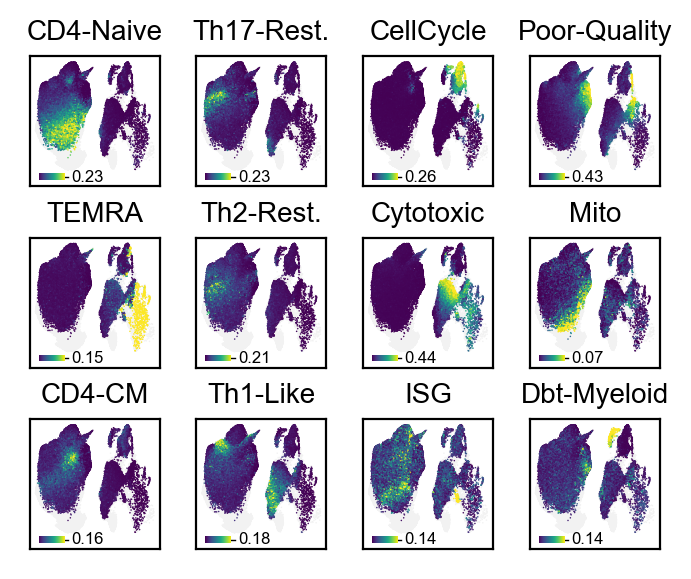

In [273]:
right = .95
left = .05
bottom = .02
top = .9
fig_width = 3.5
fig_height = 2.8
lab_fs = 10
leg_fs = 7
s=.3
quantile_thresh=.995

ncols = 4
nrows = 3
umap_dim = .65

wspace_full = (fig_width*(right-left)-umap_dim*ncols)/(ncols-1)
wspace_frac = wspace_full/umap_dim


hspace_full = (fig_height*(top-bottom)-umap_dim*nrows)/(nrows-1)
hspace_frac = hspace_full/umap_dim

fig = plt.figure(constrained_layout=False, figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, width_ratios=[umap_dim]*ncols, height_ratios=[umap_dim]*nrows,
                       bottom=bottom, left=left, right=right, top=top,  wspace=wspace_frac,
                       hspace=hspace_frac)

umap1_full = adata.obsm['X_umap_published'][:,0]
umap2_full = adata.obsm['X_umap_published'][:,1]

axes = []
for i in range(nrows):
    rowax = []
    for j in range(ncols):
        rowax.append(fig.add_subplot(gs[i, j]))
    axes.append(rowax)

umap1 = adata_sub.obsm['X_umap_published'][:,0]
umap2 = adata_sub.obsm['X_umap_published'][:,1]
gep_order = ['CD4-Naive', 'TEMRA', 'CD4-CM',
             'Th17-Resting', 'Th2-Resting', 'Th1-Like',  
            'CellCycle', 'Cytotoxic', 'ISG', 'Poor-Quality', 'Mito', 'Doublet-Myeloid',]
# gep_order = ['CD4-Naive', 'Th17-Resting', 'Th2-Resting', 'Th1-Like', 'Doublet-Myeloid', 'TEMRA',
#             'CellCycle', 'Cytotoxic',  'Poor-Quality', 'Mito', 'IL10/IL19',  'ISG']


cbar_left = 0.07
cbar_bottom = 0.05
cbar_length = 0.2
cbar_height =  0.05
cbaf_lab_fs = 6



for (count,g) in enumerate(gep_order):
    i = count % nrows
    j = int(count/nrows)
    print(i,j, g)
    vmax = np.quantile(tcat_usage_norm_fortest_smooth[g], quantile_thresh)

    axes[i][j].scatter(umap1_full, umap2_full, color='.95', edgecolor='None', s=s, label=None, rasterized=True)
    scim = axes[i][j].scatter(umap1, umap2, c=tcat_usage_norm_fortest_smooth[g], s=s, edgecolor='None', vmin=0, vmax=vmax, rasterized=True)
    axes[i][j].set_title(shorten_map[g], fontsize=lab_fs)
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])
    
    ylim = axes[i][j].get_ylim()
    axes[i][j].set_ylim(ylim[0]-.1, ylim[1])
    cax = axes[i][j].inset_axes([cbar_left, cbar_bottom, cbar_length, cbar_height], transform=axes[i][j].transAxes)
    fig.colorbar(scim, ax=axes[i][j], cax=cax, orientation='horizontal', ticks=[0, vmax])
    cax.set_xticklabels([0, '%.2f' % vmax], fontsize=4)
    cb = fig.colorbar(scim, ax=axes[i][j], cax=cax, orientation='horizontal', ticks=[])
    axes[i][j].text(cbar_left+cbar_length+.05, cbar_bottom+cbar_height/2, '%.2f' % vmax, ha='left', va='center', fontsize=cbaf_lab_fs, transform=axes[i][j].transAxes)
    axes[i][j].plot([cbar_left+cbar_length, cbar_left+cbar_length+.025], [cbar_bottom+cbar_height/2, cbar_bottom+cbar_height/2], 
                    color='k', lw=.5,  transform=axes[i][j].transAxes)
    cb.outline.set_visible(False)
    
plt.savefig(os.path.join(figdir, 'UMAP.GEPUsage.COMBAT.CD4.NonNaive.png'))
plt.savefig(os.path.join(figdir, 'UMAP.GEPUsage.COMBAT.CD4.NonNaive.pdf'))

In [274]:
tcat_usage_norm_forplot = tcat_usage_norm_fortest.loc[adata_sub.obs.index,:]

In [275]:
tcat_usage_norm_forplot.std(axis=0).sort_values(ascending=False)

Treg                   0.101950
Poor-Quality           0.086143
Cytotoxic              0.076446
Translation            0.072190
Th17-Resting           0.069457
Th2-Resting            0.063123
CD4-Naive              0.061179
CD40LG/TXNIP           0.056166
Th22                   0.053572
BCL2/FAM13A            0.051373
ISG                    0.050879
IEG                    0.046779
Th1-Like               0.045830
CD4-CM                 0.042055
Doublet-Plasmablast    0.037180
Doublet-Myeloid        0.035130
CellCycle              0.034689
TEMRA                  0.032407
MAIT                   0.031879
CD8-EM                 0.029583
IEG2                   0.028511
Tfh-2                  0.028418
Th2-Activated          0.028208
CTLA4/CD38             0.026596
CD172a/MERTK           0.026593
RGCC/MYADM             0.026418
NME1/FABP5             0.025654
CD8-Naive              0.023769
SOX4/TOX2              0.023112
Doublet-Fibroblast     0.022974
Tfh-1                  0.022898
IEG3    

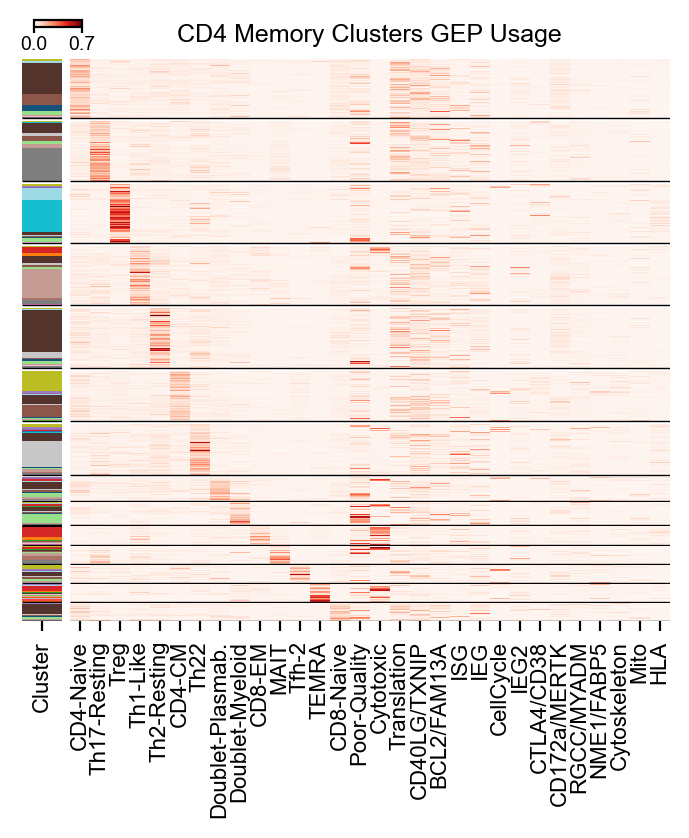

In [353]:
lineage_geps = ['Treg', 'Th17-Resting', 'Th2-Resting', 'CD4-Naive', 'Th22',
        'Th1-Like', 'CD4-CM', 'Doublet-Plasmablast', 'Doublet-Myeloid', 'TEMRA',
       'MAIT', 'CD8-EM', 'Tfh-2', 'CD8-Naive']

nonlineage_geps = ['Poor-Quality', 'Cytotoxic', 'Translation', 'CD40LG/TXNIP', 'BCL2/FAM13A',
                   'ISG', 'IEG', 'CellCycle', 'IEG2',  'CTLA4/CD38',
                  'CD172a/MERTK', 'RGCC/MYADM', 'NME1/FABP5', 'Cytoskeleton', 'Mito', 'HLA']

others = ['SOX4/TOX2', 'Doublet-Fibroblast', 'Tfh-1', 'IEG3', 
       'Doublet-Bcell', 'Th17-Activated', 'IL10/IL19',
       'ICOS/CD38', 'OX40/EBI3', 
       'Doublet-Platelet', 'gdT-Blood', 'Multi-Cytokine', 'Tph', 'Heatshock',
       'Exhaustion', 'TIMD4/TIM3', 'CD8-Trm',
       'Metallothionein', 'Doublet-RBC']

markers = ['AB_CD4-2', 'AB_CD8', 'AB_CD45RA', 'AB_CD45RO', 'SELL', 'AB_CD196', 'FOXP3', 'AB_CD161', 'GATA3']


right = .95
left = .05
bottom = .25
top = .92
fig_width = 3.6
fig_height = 4.2


cluster_bar_width = .2
gep_heatmap_width = 3
#adt_heatmap_width = 1
ncols = 2

wspace_full = (fig_width*(right-left) - gep_heatmap_width - cluster_bar_width) / (ncols-1)
wspace_frac = wspace_full/ ((gep_heatmap_width + cluster_bar_width)/2)

max_identity_usage = tcat_usage_norm_forplot[lineage_geps].idxmax(axis=1)
vc = max_identity_usage.value_counts()
vcfrac = vc.div(vc.sum())
vcfrac_adjust = vcfrac.copy()
vcfrac_adjust.loc[vcfrac_adjust>.1] = .1
vcfrac_adjust.loc[vcfrac_adjust<.03] = .03

nrows = len(vcfrac)
hspace_frac = 0


vmax = 0.7
marker_vmax = 3
ticklab_fs = 8
lab_fs = 9


fig = plt.figure(constrained_layout=False, figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, width_ratios=[cluster_bar_width, gep_heatmap_width],
                       height_ratios=vcfrac_adjust.values,
                       bottom=bottom, left=left, right=right, top=top,  wspace=wspace_frac, hspace=hspace_frac)




cluster_heatmap_ax = []
gep_heatmap_ax = []
#adt_heatmap_ax = []
for i in range(nrows):
    gep_heatmap_ax.append(fig.add_subplot(gs[i,1], xticks=[], yticks=[], frameon=False,))
    cluster_heatmap_ax.append(fig.add_subplot(gs[i, 0], xticks=[], yticks=[], frameon=False,))
    #adt_heatmap_ax.append(fig.add_subplot(gs[i,2], xticks=[], yticks=[], frameon=False,))


gep_order = list(vcfrac.index) + list(nonlineage_geps)


cbar_ax = cluster_heatmap_ax[0].inset_axes([0.3, 1.5, 1.2, .12], transform=cluster_heatmap_ax[0].transAxes)



cellorder = []
for i,identity in enumerate(vcfrac.index):
    idat = tcat_usage_norm_forplot.loc[max_identity_usage==identity, gep_order]

    #if idat.shape[0]>1000:
    #    idat = idat.sample(1000, replace=False)

    #sort_order = list(idat[nonlineage_geps].std(axis=0).sort_values(ascending=False).index)
    #idat = idat.sort_values(by=sort_order, ascending=False)
    
    #Z = linkage(idat[nonlineage_geps], method='complete')
    #cll_order = leaves_list(Z)    
    cll_order = label_clean.loc[idat.index].sort_values().index
    idat = idat.loc[cll_order, :]
    
    scim = gep_heatmap_ax[i].imshow(idat, aspect='auto', interpolation='nearest', cmap="Reds", vmin=0, vmax=vmax, rasterized=True)
    gep_heatmap_ax[i].hlines(y=idat.shape[0], xmin=0-.5, xmax=len(gep_order)-.5, linestyle='-', color='k', lw=.5)

    if i == 0:
        cb = fig.colorbar(scim, ax=gep_heatmap_ax[i], cax=cbar_ax, orientation='horizontal', ticks=[0, vmax])
        cbar_ax.tick_params(labelsize=7, length=2, pad=1)
   

    cluster_colors = np.array([cbarmapper[x] for x in label.loc[idat.index]]).reshape(-1, 1, 3)
    cluster_colors = np.repeat(cluster_colors, 2, axis=1)
    cluster_heatmap_ax[i].imshow(cluster_colors, aspect='auto', interpolation='nearest')
    cluster_heatmap_ax[i].hlines(y=idat.shape[0], xmin=0-.5, xmax=2-.5, linestyle='-', color='k', lw=.5)

    #imarkers = markers_magic.loc[idat.index, markers]
    #adt_heatmap_ax[i].imshow(imarkers, aspect='auto', interpolation='nearest', cmap="Blues", vmin=0, vmax=marker_vmax, rasterized=True)
    #adt_heatmap_ax[i].hlines(y=imarkers.shape[0], xmin=0-.5, xmax=imarkers.shape[1]-.5, linestyle='-', color='k', lw=.5)

    
    if i == (nrows-1):
        gep_heatmap_ax[i].set_xticks(np.arange(len(gep_order)))
        gep_heatmap_ax[i].set_xticklabels([x.replace('-Associated', '').replace('+-Activation', '+').replace('Plasmablast', 'Plasmab.') for x in gep_order], rotation=90, fontsize=ticklab_fs)

        cluster_heatmap_ax[i].set_xticks([0.5])
        cluster_heatmap_ax[i].set_xticklabels(['Cluster'], rotation=90, fontsize=ticklab_fs)

        #adt_heatmap_ax[i].set_xticks(np.arange(len(markers)))
        #adt_heatmap_ax[i].set_xticklabels(markers, rotation=90, fontsize=ticklab_fs)



gep_heatmap_ax[0].set_title('CD4 Memory Clusters GEP Usage', fontsize=lab_fs)


plt.savefig(os.path.join(figdir, 'Heatmap.GEPUsage.COMBAT.CD4.NonNaive.png'))
plt.savefig(os.path.join(figdir, 'Heatmap.GEPUsage.COMBAT.CD4.NonNaive.pdf'))

In [354]:
vcfrac_adjust.div(vcfrac_adjust.sum())

CD4-Naive              0.110981
Th17-Resting           0.110981
Treg                   0.110981
Th1-Like               0.110981
Th2-Resting            0.110954
CD4-CM                 0.094339
Th22                   0.094217
Doublet-Plasmablast    0.045056
Doublet-Myeloid        0.041295
CD8-EM                 0.037038
MAIT                   0.033294
Tfh-2                  0.033294
TEMRA                  0.033294
CD8-Naive              0.033294
dtype: float64

In [355]:
tcat_usage_norm_forplot

,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,Cytotoxic,Doublet-Platelet,NME1/FABP5,Th22,...,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1,CellCycle
AAACCTGCAGCTCGAC-1-gPlexA1,2.344784e-01,0.002651,0.011165,0.000005,0.000582,0.012246,0.005275,0.001425,4.072309e-02,0.076251,...,0.010843,0.044205,0.014869,0.001485,0.005787,0.031758,0.004158,0.001973,0.007829,0.003613
AAACCTGTCGGTCCGA-1-gPlexA1,8.735262e-02,0.003070,0.002035,0.000003,0.000749,0.006428,0.006487,0.002647,1.925798e-02,0.036321,...,0.014878,0.038761,0.017348,0.000928,0.002602,0.014502,0.001389,0.005250,0.004673,0.002284
AAACGGGAGCCCTAAT-1-gPlexA1,9.341568e-03,0.009855,0.024536,0.000053,0.000854,0.003308,0.012281,0.001726,7.605193e-03,0.084020,...,0.022300,0.049065,0.010315,0.001572,0.002383,0.020093,0.009664,0.074772,0.003997,0.004662
AAACGGGCACGCATCG-1-gPlexA1,5.902198e-07,0.000031,0.013592,0.000005,0.000028,0.002011,0.000139,0.000470,2.256917e-07,0.000060,...,0.006246,0.000048,0.005343,0.000007,0.000329,0.004796,0.205579,0.264110,0.019453,0.000140
AAACGGGCATAGAAAC-1-gPlexA1,1.001045e-02,0.017639,0.008502,0.000002,0.001399,0.019113,0.026346,0.001260,1.476934e-03,0.148618,...,0.004323,0.024857,0.040799,0.006793,0.001442,0.041141,0.005257,0.000451,0.000204,0.000994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGCAGTCA-1-gPlexK7,1.147198e-03,0.002301,0.006909,0.000200,0.000518,0.003624,0.005798,0.001549,2.205991e-02,0.016159,...,0.052221,0.001496,0.003573,0.000414,0.009982,0.006877,0.027749,0.013896,0.122073,0.179696
TTTGGTTGTAGCCTCG-1-gPlexK7,6.355499e-04,0.000201,0.212569,0.000051,0.000711,0.001765,0.008676,0.001069,3.969192e-04,0.025682,...,0.004166,0.024424,0.034804,0.002338,0.006784,0.128573,0.006102,0.002560,0.012404,0.000274
TTTGGTTGTCAGGACA-1-gPlexK7,4.311827e-03,0.000111,0.081707,0.000213,0.000605,0.012133,0.011758,0.000706,3.414959e-04,0.024606,...,0.002381,0.006535,0.005327,0.003514,0.002249,0.031300,0.003357,0.008696,0.036541,0.002212
TTTGGTTGTCTAGAGG-1-gPlexK7,4.214761e-05,0.004359,0.264350,0.000080,0.001190,0.002862,0.051090,0.001122,3.147720e-04,0.222362,...,0.000918,0.001023,0.001668,0.000448,0.000187,0.028818,0.021154,0.001380,0.000903,0.011686


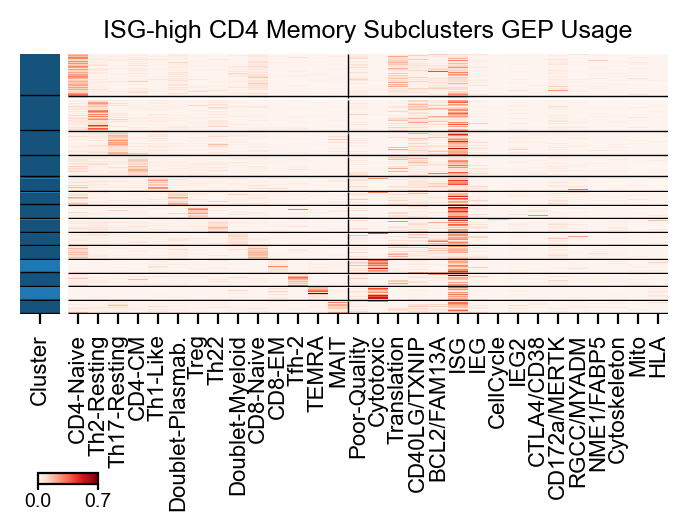

In [364]:
subset = adata_sub.obs.index[adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.Th.IFN.resp', 'CD4.TEM.IFN.resp'])]

lineage_geps = ['Treg', 'Th17-Resting', 'Th2-Resting', 'CD4-Naive', 'Th22',
        'Th1-Like', 'CD4-CM', 'Doublet-Plasmablast', 'Doublet-Myeloid', 'TEMRA',
       'MAIT', 'CD8-EM', 'Tfh-2', 'CD8-Naive']

nonlineage_geps = ['Poor-Quality', 'Cytotoxic', 'Translation', 'CD40LG/TXNIP', 'BCL2/FAM13A',
                   'ISG', 'IEG', 'CellCycle', 'IEG2',  'CTLA4/CD38',
                  'CD172a/MERTK', 'RGCC/MYADM', 'NME1/FABP5', 'Cytoskeleton', 'Mito', 'HLA']


others = ['SOX4/TOX2', 'Doublet-Fibroblast', 'Tfh-1', 'IEG3', 
       'Doublet-Bcell', 'Th17-Activated', 'IL10/IL19',
       'ICOS/CD38', 'OX40/EBI3', 
       'Doublet-Platelet', 'gdT-Blood', 'Multi-Cytokine', 'Tph', 'Heatshock',
       'Exhaustion', 'TIMD4/TIM3', 'CD8-Trm',
       'Metallothionein', 'Doublet-RBC']

markers = ['AB_CD4-2', 'AB_CD8', 'AB_CD45RA', 'AB_CD45RO', 'SELL', 'AB_CD196', 'FOXP3', 'AB_CD161', 'GATA3']


right = .95
left = .05
bottom = .4
top = .9
fig_width = 3.6
fig_height = 2.6


cluster_bar_width = .2
gep_heatmap_width = 3
#adt_heatmap_width = 1
ncols = 2

wspace_full = (fig_width*(right-left) - gep_heatmap_width - cluster_bar_width) / (ncols-1)
wspace_frac = wspace_full/ ((gep_heatmap_width + cluster_bar_width)/2)



tcat_usage_norm_forplot_sub = tcat_usage_norm_forplot.loc[subset, :]


max_identity_usage = tcat_usage_norm_forplot_sub[lineage_geps].idxmax(axis=1)
vc = max_identity_usage.value_counts()
vcfrac = vc.div(vc.sum())
vcfrac_adjust = vcfrac.copy()
vcfrac_adjust.loc[vcfrac_adjust>.1] = .1
vcfrac_adjust.loc[vcfrac_adjust<.03] = .03

nrows = len(vcfrac)
hspace_frac = 0.0


vmax = 0.7
marker_vmax = 3
ticklab_fs = 8
lab_fs = 9


fig = plt.figure(constrained_layout=False, figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, width_ratios=[cluster_bar_width, gep_heatmap_width],
                       height_ratios=vcfrac_adjust.values,
                       bottom=bottom, left=left, right=right, top=top,  wspace=wspace_frac, hspace=hspace_frac)




cluster_heatmap_ax = []
gep_heatmap_ax = []
#adt_heatmap_ax = []
for i in range(nrows):
    gep_heatmap_ax.append(fig.add_subplot(gs[i,1], xticks=[], yticks=[], frameon=False,))
    cluster_heatmap_ax.append(fig.add_subplot(gs[i, 0], xticks=[], yticks=[], frameon=False,))
    #adt_heatmap_ax.append(fig.add_subplot(gs[i,2], xticks=[], yticks=[], frameon=False,))


gep_order = list(vcfrac.index) + list(nonlineage_geps)


#cbar_ax = cluster_heatmap_ax[0].inset_axes([0.3, 1.55, 1.2, .12], transform=cluster_heatmap_ax[0].transAxes)
x=nrows-1
cbar_ax = gep_heatmap_ax[x].inset_axes([-.05, -12.5, .1, .8])



cellorder = []
for i,identity in enumerate(vcfrac.index):
    idat = tcat_usage_norm_forplot_sub.loc[max_identity_usage==identity, gep_order]

    #if idat.shape[0]>1000:
    #    idat = idat.sample(1000, replace=False)

    #sort_order = list(idat[nonlineage_geps].std(axis=0).sort_values(ascending=False).index)
    #idat = idat.sort_values(by=sort_order, ascending=False)
    
    #Z = linkage(idat[nonlineage_geps], method='complete')
    #cll_order = leaves_list(Z)    
    cll_order = label_clean.loc[idat.index].sort_values().index
    idat = idat.loc[cll_order, :]
    
    scim = gep_heatmap_ax[i].imshow(idat, aspect='auto', interpolation='nearest', cmap="Reds", vmin=0, vmax=vmax, rasterized=True)
        
    ylim = gep_heatmap_ax[i].get_ylim()
    gep_heatmap_ax[i].hlines(y=idat.shape[0]*.96, xmin=0-.5, xmax=len(gep_order)-.5, linestyle='-', color='k', lw=.5, zorder=10)
    gep_heatmap_ax[i].vlines(x=len(lineage_geps)-.5, ymin=0-.5, ymax=idat.shape[0], linestyle='-', color='k', lw=.5)
    if i == 0:
        cb = fig.colorbar(scim, ax=gep_heatmap_ax[i], cax=cbar_ax, orientation='horizontal', ticks=[0, vmax])
        cbar_ax.tick_params(labelsize=7, length=2, pad=1)
       
    cluster_colors = np.array([cbarmapper[x] for x in label.loc[idat.index]]).reshape(-1, 1, 3)
    cluster_colors = np.repeat(cluster_colors, 2, axis=1)
    cluster_heatmap_ax[i].imshow(cluster_colors, aspect='auto', interpolation='nearest')
    cluster_heatmap_ax[i].hlines(y=idat.shape[0]*.9, xmin=0-.5, xmax=2-.5, linestyle='-', color='k', lw=.5)

    #imarkers = markers_magic.loc[idat.index, markers]
    #adt_heatmap_ax[i].imshow(imarkers, aspect='auto', interpolation='nearest', cmap="Blues", vmin=0, vmax=marker_vmax, rasterized=True)
    #adt_heatmap_ax[i].hlines(y=imarkers.shape[0], xmin=0-.5, xmax=imarkers.shape[1]-.5, linestyle='-', color='k', lw=.5)

    
    if i == (nrows-1):
        gep_heatmap_ax[i].set_xticks(np.arange(len(gep_order)))
        gep_heatmap_ax[i].set_xticklabels([x.replace('-Associated', '').replace('+-Activation', '+').replace('Plasmablast', 'Plasmab.') for x in gep_order], rotation=90, fontsize=ticklab_fs)

        cluster_heatmap_ax[i].set_xticks([0.5])
        cluster_heatmap_ax[i].set_xticklabels(['Cluster'], rotation=90, fontsize=ticklab_fs)

        #adt_heatmap_ax[i].set_xticks(np.arange(len(markers)))
        #adt_heatmap_ax[i].set_xticklabels(markers, rotation=90, fontsize=ticklab_fs)



gep_heatmap_ax[0].set_title('ISG-high CD4 Memory Subclusters GEP Usage', fontsize=lab_fs)

plt.savefig(os.path.join(figdir, 'Heatmap.GEPUsage.COMBAT.ISG+.CD4.NonNaive.png'))
plt.savefig(os.path.join(figdir, 'Heatmap.GEPUsage.COMBAT.ISG+.CD4.NonNaive.pdf'))

In [365]:
.1 / vcfrac_adjust

CD4-Naive              1.000000
Th2-Resting            1.342532
Th17-Resting           1.900717
CD4-CM                 2.182305
Th1-Like               3.213939
Doublet-Plasmablast    3.333333
Treg                   3.333333
Th22                   3.333333
Doublet-Myeloid        3.333333
CD8-Naive              3.333333
CD8-EM                 3.333333
Tfh-2                  3.333333
TEMRA                  3.333333
MAIT                   3.333333
dtype: float64

In [366]:
set([cbarmapper[x] for x in label.loc[idat.index]])

{(0.08509803921568632, 0.3266666666666665, 0.4941176470588235),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}

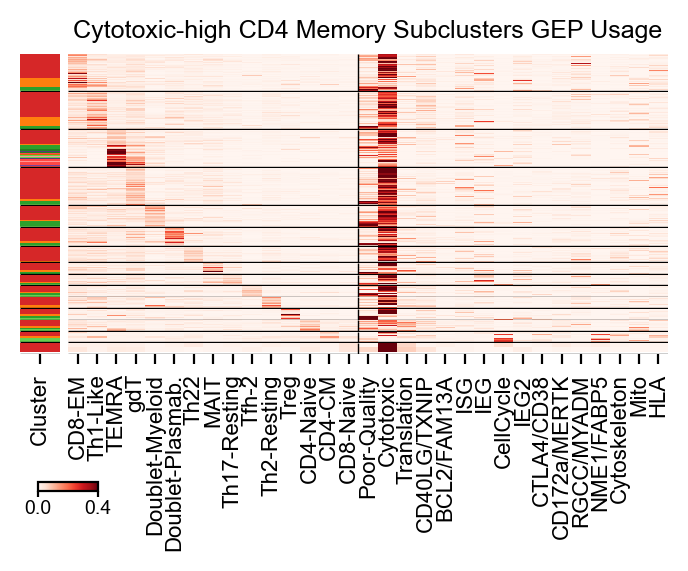

In [367]:
subset = adata_sub.obs.index[adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.TEMRA', 'CD4.TEM', 'CD4.TEMRA.KLRB1', 'CD4.TEMRA.XCL2',  'CD4.TEMRA.KLRC3',  'CD4.TEM.GZMK',
            'CD4.TEMRA.mitohi', 'CD4.TEM.mitohi.1','CD4.TEM.mitohi.2', 'CD4.TEFF.prolif.GZMB.2', 'CD4.TEFF.prolif.GZMB.1'])]

lineage_geps = ['Treg', 'Th17-Resting', 'Th2-Resting', 'CD4-Naive', 'Th22',
        'Th1-Like', 'CD4-CM', 'Doublet-Plasmablast', 'Doublet-Myeloid', 'TEMRA',
       'MAIT', 'CD8-EM', 'Tfh-2', 'CD8-Naive', 'gdT']

nonlineage_geps = ['Poor-Quality', 'Cytotoxic', 'Translation', 'CD40LG/TXNIP', 'BCL2/FAM13A',
                   'ISG', 'IEG', 'CellCycle', 'IEG2',  'CTLA4/CD38',
                  'CD172a/MERTK', 'RGCC/MYADM', 'NME1/FABP5', 'Cytoskeleton', 'Mito', 'HLA']


others = ['SOX4/TOX2', 'Doublet-Fibroblast', 'Tfh-1', 'IEG3', 
       'Doublet-Bcell', 'Th17-Activated', 'IL10/IL19',
       'ICOS/CD38', 'OX40/EBI3', 
       'Doublet-Platelet', 'gdT-Blood', 'Multi-Cytokine', 'Tph', 'Heatshock',
       'Exhaustion', 'TIMD4/TIM3', 'CD8-Trm',
       'Metallothionein', 'Doublet-RBC']

markers = ['AB_CD4-2', 'AB_CD8', 'AB_CD45RA', 'AB_CD45RO', 'SELL', 'AB_CD196', 'FOXP3', 'AB_CD161', 'GATA3']


right = .95
left = .05
bottom = .4
top = .9
fig_width = 3.6
fig_height = 3.0


cluster_bar_width = .2
gep_heatmap_width = 3
#adt_heatmap_width = 1
ncols = 2

wspace_full = (fig_width*(right-left) - gep_heatmap_width - cluster_bar_width) / (ncols-1)
wspace_frac = wspace_full/ ((gep_heatmap_width + cluster_bar_width)/2)



tcat_usage_norm_forplot_sub = tcat_usage_norm_forplot.loc[subset, :]


max_identity_usage = tcat_usage_norm_forplot_sub[lineage_geps].idxmax(axis=1)
max_identity_usage_value = tcat_usage_norm_forplot_sub[lineage_geps].max(axis=1)

vc = max_identity_usage.value_counts()
vcfrac = vc.div(vc.sum())
vcfrac_adjust = vcfrac.copy()
vcfrac_adjust.loc[vcfrac_adjust>.1] = .1
vcfrac_adjust.loc[vcfrac_adjust<.03] = .03

nrows = len(vcfrac)
hspace_frac = 0


vmax = 0.4
marker_vmax = 3
ticklab_fs = 8
lab_fs = 9


fig = plt.figure(constrained_layout=False, figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, width_ratios=[cluster_bar_width, gep_heatmap_width],
                       height_ratios=vcfrac_adjust.values,
                       bottom=bottom, left=left, right=right, top=top,  wspace=wspace_frac, hspace=hspace_frac)




cluster_heatmap_ax = []
gep_heatmap_ax = []
#adt_heatmap_ax = []
for i in range(nrows):
    gep_heatmap_ax.append(fig.add_subplot(gs[i,1], xticks=[], yticks=[], frameon=False,))
    cluster_heatmap_ax.append(fig.add_subplot(gs[i, 0], xticks=[], yticks=[], frameon=False,))
    #adt_heatmap_ax.append(fig.add_subplot(gs[i,2], xticks=[], yticks=[], frameon=False,))


gep_order = list(vcfrac.index) + list(nonlineage_geps)

x=nrows-1
cbar_ax = gep_heatmap_ax[x].inset_axes([-.05, -12, .1, .8])



cellorder = []
for i,identity in enumerate(vcfrac.index):
    idat = tcat_usage_norm_forplot_sub.loc[max_identity_usage==identity, gep_order]

    #if idat.shape[0]>1000:
    #    idat = idat.sample(1000, replace=False)

    #sort_order = list(idat[nonlineage_geps].std(axis=0).sort_values(ascending=False).index)
    #idat = idat.sort_values(by=sort_order, ascending=False)
    
    #Z = linkage(idat[nonlineage_geps], method='complete')
    #cll_order = leaves_list(Z)    
    cll_order = label_clean.loc[idat.index].sort_values().index
    idat = idat.loc[cll_order, :]
    
    scim = gep_heatmap_ax[i].imshow(idat, aspect='auto', interpolation='nearest', cmap="Reds", vmin=0, vmax=vmax, rasterized=True)
    gep_heatmap_ax[i].hlines(y=idat.shape[0], xmin=0-.5, xmax=len(gep_order)-.5, linestyle='-', color='k', lw=.5)

    if i == 0:
        cb = fig.colorbar(scim, ax=gep_heatmap_ax[i], cax=cbar_ax, orientation='horizontal', ticks=[0, vmax])
        cbar_ax.tick_params(labelsize=7, length=2, pad=1)
   

    cluster_colors = np.array([cbarmapper[x] for x in label.loc[idat.index]]).reshape(-1, 1, 3)
    cluster_colors = np.repeat(cluster_colors, 2, axis=1)
    cluster_heatmap_ax[i].imshow(cluster_colors, aspect='auto', interpolation='nearest')
    cluster_heatmap_ax[i].hlines(y=idat.shape[0], xmin=0-.5, xmax=2-.5, linestyle='-', color='k', lw=.5)
    gep_heatmap_ax[i].vlines(x=len(lineage_geps)-.5, ymin=0-.5, ymax=idat.shape[0], linestyle='-', color='k', lw=.5)

    
    
    #imarkers = markers_magic.loc[idat.index, markers]
    #adt_heatmap_ax[i].imshow(imarkers, aspect='auto', interpolation='nearest', cmap="Blues", vmin=0, vmax=marker_vmax, rasterized=True)
    #adt_heatmap_ax[i].hlines(y=imarkers.shape[0], xmin=0-.5, xmax=imarkers.shape[1]-.5, linestyle='-', color='k', lw=.5)

    
    if i == (nrows-1):
        gep_heatmap_ax[i].set_xticks(np.arange(len(gep_order)))
        gep_heatmap_ax[i].set_xticklabels([x.replace('-Associated', '').replace('+-Activation', '+').replace('Plasmablast', 'Plasmab.') for x in gep_order], rotation=90, fontsize=ticklab_fs)

        cluster_heatmap_ax[i].set_xticks([0.5])
        cluster_heatmap_ax[i].set_xticklabels(['Cluster'], rotation=90, fontsize=ticklab_fs)

        #adt_heatmap_ax[i].set_xticks(np.arange(len(markers)))
        #adt_heatmap_ax[i].set_xticklabels(markers, rotation=90, fontsize=ticklab_fs)



gep_heatmap_ax[0].set_title('Cytotoxic-high CD4 Memory Subclusters GEP Usage', fontsize=lab_fs)
plt.savefig(os.path.join(figdir, 'Heatmap.GEPUsage.COMBAT.Cytotoxic+.CD4.NonNaive.png'))
plt.savefig(os.path.join(figdir, 'Heatmap.GEPUsage.COMBAT.Cytotoxic+.CD4.NonNaive.pdf'))

In [111]:
label_clean.loc[subset].unique()

array(['Other', 'CD4.TEM.mitohi.1', 'CD4.TEM', 'CD4.TEM.GZMK'],
      dtype=object)

In [118]:
label_clean_sub = label_clean.loc[subset]
adata.obs.loc[label_clean_sub.index[label_clean_sub=='Other'], :]

,Annotation_cluster_name,Annotation_minor_subset,Annotation_major_subset,Annotation_cell_type,GEX_region,QC_ngenes,QC_total_UMI,QC_pct_mitochondrial,QC_scrub_doublet_scores,TCR_chain_composition,...,Ethnicity,Tissue,DiseaseClassification,Pool_ID,Channel_ID,Manual Gating,Is_CD4_Mem,Max_Lineage,Max_Lineage_Value,Naive_Status
AAAGATGAGACCTAGG-1-gPlexA1,CD4.TEMRA.KLRB1,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,2627,10232,1.417123,0.246226,double_alpha_beta,...,Unknown,Blood;UBERON:0000178,COVID-19;MONDO:0100096,gPlexA,A1,CD8_TEMRA,True,TEMRA,0.229850,"Mem. Cluster, Low Naive Usage"
ACTGATGAGCCGGTAA-1-gPlexA1,CD4.TEM.mitohi.2,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,904,1656,3.442029,0.065142,double_alpha_beta,...,Unknown,Blood;UBERON:0000178,Sepsis;HP:0100806,gPlexA,A1,CD8_EM,True,Tfh-2,0.052830,"Mem. Cluster, Low Naive Usage"
AGGGAGTGTACGACCC-1-gPlexA1,CD4.TEMRA.XCL2,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,1206,3599,3.417616,0.168425,double_alpha_beta,...,Unknown,Blood;UBERON:0000178,COVID-19;MONDO:0100096,gPlexA,A1,DP,True,TEMRA,0.373396,"Mem. Cluster, Low Naive Usage"
CGTCAGGGTCGAGTTT-1-gPlexA1,CD4.TEMRA.KLRB1,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,2260,7697,1.390152,0.022961,double_beta,...,Unknown,Blood;UBERON:0000178,COVID-19;MONDO:0100096,gPlexA,A1,CD4_Naive,True,TEMRA,0.638101,"Mem. Cluster, Low Naive Usage"
CGTGAGCTCCACGAAT-1-gPlexA1,CD4.TEMRA.KLRB1,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,2159,7984,0.826653,0.113868,single_beta,...,Unknown,Blood;UBERON:0000178,COVID-19;MONDO:0100096,gPlexA,A1,CD4_Naive,True,TEMRA,0.320675,"Mem. Cluster, Low Naive Usage"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACCCACTCAGCCTATA-1-gPlexK7,CD4.TEMRA.KLRB1,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,1406,3131,1.469179,0.049545,double_alpha_beta,...,Unknown,Blood;UBERON:0000178,COVID-19;MONDO:0100096,gPlexK,K7,CD8_TEMRA,True,TEMRA,0.191920,"Mem. Cluster, Low Naive Usage"
GACCAATCATCCCACT-1-gPlexK7,CD4.TEMRA.KLRB1,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,1513,3382,3.577765,0.068154,double_alpha_beta,...,Unknown,Blood;UBERON:0000178,NA,gPlexK,K7,CD4_Naive,True,gdT,0.350089,"Mem. Cluster, Low Naive Usage"
GCAATCAAGTGACATA-1-gPlexK7,CD4.TEMRA.KLRB1,CD4.TEM/TEMRA,CD4,T,B: TEM/prolif. T/NK cells,1595,3665,3.656207,0.068154,nan,...,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexK,K7,CD4_TEMRA,True,TEMRA,0.517243,"Mem. Cluster, Low Naive Usage"
TGGTTAGTCGGCGCAT-1-gPlexK7,CD4.TEFF.prolif.GZMB.1,CD4.TEFF.prolif,CD4,T,B: TEM/prolif. T/NK cells,3059,11461,3.603525,0.081006,nan,...,Unknown,Blood;UBERON:0000178,COVID-19;MONDO:0100096,gPlexK,K7,CD4_Naive,True,TEMRA,0.317365,"Mem. Cluster, Low Naive Usage"


Other
CD4.TEM.mitohi.1
CD4.TEM
CD4.TEM.GZMK


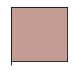

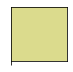

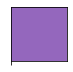

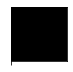

In [113]:
for x in label_clean.loc[subset].unique():
    print(x)
    sns.palplot([cbarmapper[x]])

In [102]:
adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.TEMRA', 'CD4.TEM', 'CD4.TEMRA.KLRB1', 'CD4.TEMRA.XCL2',  'CD4.TEMRA.KLRC3',  'CD4.TEM.GZMK',
            'CD4.TEMRA.mitohi', 'CD4.TEM.mitohi.1','CD4.TEM.mitohi.2', 'CD4.TEFF.prolif.GZMB.2', 'CD4.TEFF.prolif.GZMB.1'])

AAACCTGCAGCTCGAC-1-gPlexA1    False
AAACCTGTCGGTCCGA-1-gPlexA1    False
AAACGGGAGCCCTAAT-1-gPlexA1    False
AAACGGGCACGCATCG-1-gPlexA1    False
AAACGGGCATAGAAAC-1-gPlexA1    False
                              ...  
TTTGGTTAGGCAGTCA-1-gPlexK7    False
TTTGGTTGTAGCCTCG-1-gPlexK7    False
TTTGGTTGTCAGGACA-1-gPlexK7    False
TTTGGTTGTCTAGAGG-1-gPlexK7    False
TTTGGTTGTTGTCGCG-1-gPlexK7    False
Name: Annotation_cluster_name2, Length: 145475, dtype: bool

In [470]:
all_max_lin = tcat_usage_norm[lineage_geps].idxmax(axis=1)
all_max_lin_vals = tcat_usage_norm[lineage_geps].max(axis=1)
lin_info = pd.concat([all_max_lin, all_max_lin_vals], axis=1)
lin_info.columns=['Max_Lineage', 'Max_Lineage_Usage']
lin_info['Cytotoxic'] = tcat_usage_norm['Cytotoxic']
lin_info['In_Plot'] = lin_info.index.isin(max_identity_usage.index)

In [414]:
magic_markers = pd.read_csv('../../Data/PerDataset/COMBAT/ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv', sep='\t', index_col=0)
magic_markers.head()

,TRAC,TRGC1,TRDC,TRBC1,IL2RA,FOXP3,SELL,CCR7,KLRB1,RTKN2,...,AB_CD4-2,AB_CD31,AB_CD18,AB_CD127,AB_CXCR3,AB_CD194,AB_CD3-1,AB_CD8,AB_CD49b,AB_CD62L
AAACCTGAGCGGATCA-1-gPlexA1,0.671785,0.152742,0.066597,0.984844,0.081388,0.000000,0.289349,0.006257,0.852988,0.000156,...,0.522200,1.308746,3.308349,1.312492,2.735864,0.694457,4.885272,2.325313,0.622996,1.155068
AAACCTGCAGCTCGAC-1-gPlexA1,0.806843,0.000616,0.010191,0.611282,0.285519,0.019913,1.043739,0.637578,1.034146,0.216537,...,2.600563,0.927331,2.565782,3.057368,3.145195,0.970410,5.939430,0.283295,0.611673,2.212586
AAACCTGCATCTATGG-1-gPlexA1,0.732119,0.078640,0.039951,0.785795,0.000000,0.000000,0.743849,0.274476,0.189331,0.018344,...,1.910935,1.219310,3.257366,2.447848,2.978127,0.759889,5.104322,0.941336,0.894790,1.189908
AAACCTGGTCTCTCTG-1-gPlexA1,0.683763,0.023016,0.008670,0.754012,0.173426,0.017443,1.665534,1.315669,0.164243,0.135068,...,2.577428,0.781459,2.419437,2.967827,2.859445,1.093883,5.731300,0.227843,0.435720,1.788838
AAACCTGTCACCGGGT-1-gPlexA1,0.856858,0.407762,0.226991,0.992482,0.000000,0.047988,0.366300,0.019988,0.658039,0.310168,...,0.351156,2.392427,2.833467,0.875060,2.848267,0.674181,5.000405,2.054223,0.880324,1.033097


In [432]:
adt_adata = sc.read('../../Data/PerDataset/COMBAT/ADT_TP10KCLR_ForMAGIC.h5ad')

In [433]:
rna_adata = sc.read('../../Data/PerDataset/COMBAT/RNA_logTP1K_ForMAGIC.h5ad')

In [525]:
genes = ['AB_CD4-2', 'AB_CD8', 'FOXP3', 'AB_CD25', 'AB_CD194', 'CCR6', 'CCR4', 'AB_CD161', 'GZMB','GZMH', 'SLC4A10']
adt_genes = ['AB_CD4-2', 'AB_CD8', 'AB_CD25', 'AB_CD194','AB_CD161', 'AB_TCR-V-7.2', 'AB_TCR-Vd2', 'AB_CXCR3', 'AB_CD45RO', 'AB_CD158b' ]
rna_genes = [ 'FOXP3', 'CCR6', 'CCR4', 'GZMB', 'GZMH', 'SLC4A10', 'TRDC', 'RTKN2', 'CXCR3', 'SELL', 'CCR7', 'LIMS1', 'ITM2A', 'LYAR', 'GZMK', 'NSG1',
            'KIR2DL3', 'KLRC2', 'TYROBP', 'CCR6', 'CTSH', 'AQP3']

adt_gene_data = pd.DataFrame(adt_adata[:,adt_genes].X.toarray(), index=adt_adata.obs.index, columns=adt_genes)
rna_gene_data = pd.DataFrame(rna_adata[:,rna_genes].X.toarray(), index=rna_adata.obs.index, columns=rna_genes)

gene_data = pd.concat([rna_gene_data, adt_gene_data], axis=1)

In [526]:
#flat = magic_markers[['AB_CD4-2', 'AB_CD8', 'FOXP3', 'AB_CD25', 'AB_CD196', 'AB_CD194', 'GATA3', 'CCR6', 'CCR4', 'AB_CD161', 'GZMB']].unstack().reset_index()
flat = gene_data.unstack().reset_index()
flat.columns = ['Marker', 'Cell', 'Expression']
lin_info_merged = pd.merge(left=lin_info, right=flat, left_index=True, right_on='Cell', how='right')
lin_info_merged.head()

,Max_Lineage,Max_Lineage_Usage,Cytotoxic,In_Plot,Marker,Cell,Expression
0,Treg,0.034980,0.328680,False,FOXP3,AAACCTGAGCGGATCA-1-gPlexA1,0.0
1,CCR10-Migration,0.076251,0.005275,False,FOXP3,AAACCTGCAGCTCGAC-1-gPlexA1,0.0
2,CD8-EM,0.155859,0.120184,False,FOXP3,AAACCTGCATCTATGG-1-gPlexA1,0.0
3,Th17,0.066082,0.010866,False,FOXP3,AAACCTGGTCTCTCTG-1-gPlexA1,0.0
4,CD8-EM,0.363029,0.082531,False,FOXP3,AAACCTGTCACCGGGT-1-gPlexA1,0.0


In [520]:
counts

{'Non-cyto Other': 1979628,
 'Cyto Other': 731136,
 'Non-cyto NK-like': 20048,
 'Cyto NK-like': 307552}

In [229]:
adata_sub.obs['Annotation_cluster_name2'].isin(['CD4.TEMRA', 'CD4.TEM', 'CD4.TEMRA.KLRB1', 'CD4.TEMRA.XCL2',  'CD4.TEMRA.KLRC3',  'CD4.TEM.GZMK',
            'CD4.TEMRA.mitohi', 'CD4.TEM.mitohi.1','CD4.TEM.mitohi.2', 'CD4.TEFF.prolif.GZMB.2', 'CD4.TEFF.prolif.GZMB.1']).value_counts()

False    136314
True       9161
Name: Annotation_cluster_name2, dtype: int64

## Myeloid plot

In [94]:
tpm_fn = ref_info.loc['COMBAT', 'tpm_counts_for_cnmf_fn']
adata_logtp10k = sc.read(tpm_fn)
adata_logtp10k = adata_logtp10k[:,[x for x in adata_logtp10k.var.index if 'AB_' not in x]]
sc.pp.log1p(adata_logtp10k)

Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [95]:
cgepinfo = read_dataset_log(tabname='cGEP Paths')
gene_scores_fn = cgepinfo.loc[0, 'scores_spectra']
gene_scores = pd.read_csv(gene_scores_fn, sep='\t', index_col=0).T
gene_scores = gene_scores.rename(columns=rename_map)


ccgeps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']
gene_scores['CellCycle'] = gene_scores[ccgeps].sum(axis=1)
gene_scores.drop(ccgeps, axis=1, inplace=True)
gene_scores = gene_scores.loc[gene_scores.index.isin(adata.var.index), :]

ntopgenes = 500
topgenes = {}
for g in gene_scores.columns:
    topgenes[g] = list(gene_scores.sort_values(by=g, ascending=False).index[:ntopgenes])

topgenes = pd.DataFrame(topgenes)

topgenes.head()

,Translation,HLA,ISG,Mito,Doublet-RBC,gdT-Blood,Cytotoxic,Doublet-Platelet,Early-Activation,CCR10-Migration,...,OX40/EBI3-Activation,TXNIP/H1FX,YPEL5/JUNB,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1,CellCycle
0,RPS18,HLA-DRA,ISG15,MT-CO2,HBA2,TRDV2,FGFBP2,PPBP,NME1,CCR10,...,EBI3,TXNIP,YPEL5,LUM,SOX4,CD40LG,LAG3,LAG3,TOX2,TYMS
1,RPS6,HLA-DRB1,MX1,MT-CYB,HBA1,TRDC,GZMH,NRGN,FABP5,S100A10,...,TNFRSF4,AB_CD324,JUNB,COL1A2,PRDM16,TXNIP,LAIR2,HAVCR2,SMCO4,STMN1
2,RPS12,CD74,IFIT3,MT-CO3,HBB,AB_TCR-Vd2,NKG7,TREML1,HSP90AB1,LGALS1,...,TNFRSF18,CXCR4,NR4A2,COL3A1,MME,FKBP5,SLC27A2,TIMD4,KSR2,RRM2
3,RPL3,HLA-DQA1,IFI6,MT-ATP6,HBM,TRGV9,PRF1,SPARC,C1QBP,LMNA,...,PKM,PLP2,EIF1,DCN,SMIM24,CH25H,PDCD1,TMEM155,PEG10,MKI67
4,RPS3,HLA-DQB1,IFIT1,MT-CO1,AB_CD235ab,KLRC1,PRSS23,TUBB1,PAICS,S100A6,...,CCL22,RPL30,PPP1R15A,FN1,CHST2,CRYBG1,CD4,PTMS,CXCR5,UBE2C


In [96]:
topgenes['Doublet-Myeloid'].head(20).values

array(['S100A8', 'S100A9', 'LYZ', 'S100A12', 'VCAN', 'CST3', 'MNDA',
       'FCN1', 'AB_CLEC12A', 'AB_CD33', 'AB_CD35', 'FCER1G',
       'AB_Iglightchaink', 'IFI30', 'AB_CD11b-1', 'AB_CD32', 'AB_CD64',
       'CD14', 'CSF3R', 'IL1B'], dtype=object)

In [97]:
genes = ['LYZ', 'CST3', 'MNDA', 'CD14']
gene_data = pd.DataFrame(adata_logtp10k[:, genes].X.toarray(), index=adata_logtp10k.obs.index, columns=genes)
gene_data_unstack = pd.merge(left=gene_data.unstack().reset_index(), right=adata_logtp10k.obs[['Annotation_cluster_name', 'Annotation_minor_subset']], left_on='level_1', right_index=True)

cd4_mem_clusters = [ 'CD4.TCM', 'CD4.TEFF', 'CD4.TEFF.prolif', 'CD4.TEM/TEMRA', 'CD4.TREG']
gene_data_unstack = gene_data_unstack.loc[gene_data_unstack['Annotation_minor_subset'].isin(cd4_mem_clusters), :]
gene_data_unstack['Cluster'] = (gene_data_unstack['Annotation_cluster_name']=='CD4.TEFF.prolif.MKI67lo').replace({True:'CD4.TEFF.prolif.MKI67lo', False:'Other'})

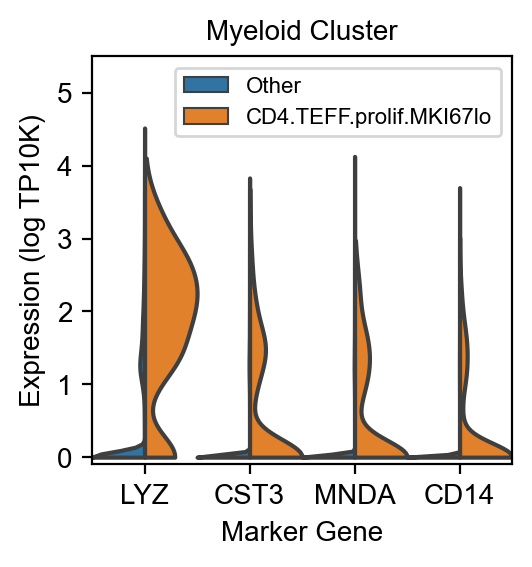

In [98]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'bottom':.2, 'left':.2})
sns.violinplot(x='level_0', y=0, hue='Cluster', data=gene_data_unstack,  split=True, width=1, cut=0, scale='width', ax=ax, inner=None)
ax.set_ylim([-.1, 5.5])
ax.legend(fontsize=8)
ax.set_xlabel('Marker Gene', fontsize=10)
ax.set_ylabel('Expression (log TP10K)', fontsize=10)
ax.set_title('Myeloid Cluster', fontsize=10)

plt.savefig(os.path.join(figdir, 'COMBAT.MyeloidCluster.Violin.png'))
plt.savefig(os.path.join(figdir, 'COMBAT.MyeloidCluster.Violin.pdf'))